In [4]:
from torch.utils.data import Dataset, DataLoader
import json
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

### Setting up inputs and outputs

In [5]:
file = '/home/laurie2905/mase_ADL/mase/NASLib/naslib/data/zc_nasbench201.json'
with open(file, 'r') as f:
    data = json.load(f)
    data = data['cifar10']


targets = [data[arch]['val_accuracy'] for arch in data.keys()]
inputs = []

for arch in data.keys():

    inputs.append([data[arch].get(metric_name, 0)['score'] for metric_name in ['epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot','plain','snip','synflow','zen','flops','params'] ])
    

### Defining dataloader with the capacity to only use a portion of data

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, inputs, targets, use_percentage=1.0):
        # Assuming inputs and targets are PyTorch tensors
        assert 0 < use_percentage <= 1, "use_percentage must be within (0, 1)."
        num_samples = int(len(inputs) * use_percentage)
        self.inputs = inputs[:num_samples]
        self.targets = targets[:num_samples]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]# Create dataset instances using a subset of the data
use_percentage = 0.5  # Use 50% of the data
train_dataset = CustomDataset(inputs_train, targets_train, use_percentage=use_percentage)
test_dataset = CustomDataset(inputs_test, targets_test, use_percentage=use_percentage)

batch_size = 32  # Adjustable batch size

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Setting up models and training

In [ ]:
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(13, 1)
        # 3 inputs (zc metrics), 1 output (accuracy)

    def forward(self, x):
        return self.linear(x)
    
import torch.nn as nn
import torch.nn.functional as F

class NonLinearModel(nn.Module):
    def __init__(self):
        super(NonLinearModel, self).__init__()
        self.linear1 = nn.Linear(13, 13)  # First linear layer
        self.act1 = nn.ReLU()            # Non-linear activation function
        self.linear2 = nn.Linear(13, 1)  # Second linear layer to produce 1 output

    def forward(self, x):
        x = self.linear1(x)  # Pass input through the first linear layer
        x = self.act1(x)     # Apply non-linear activation
        x = self.linear2(x)  # Pass through the second linear layer
        return x

# model = NonLinearModel()

model = LinearModel()

# Loss and optimizer
criterion = nn.L1Loss()
# criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

# Tracking loss for plotting
train_losses = []
test_losses = []

epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss_train = 0.0
    for inputs_batch, targets_batch in train_loader:
        optimizer.zero_grad()
        outputs_train = model(inputs_batch)
        loss_train = criterion(outputs_train, targets_batch)
        loss_train.backward()
        optimizer.step()
        running_loss_train += loss_train.item() * inputs_batch.size(0)
    
    epoch_loss_train = running_loss_train / len(train_loader.dataset)

    # Evaluation mode (no gradients)
    model.eval()
    running_loss_test = 0.0
    with torch.no_grad():
        for inputs_batch, targets_batch in test_loader:
            outputs_test = model(inputs_batch)
            loss_test = criterion(outputs_test, targets_batch)
            running_loss_test += loss_test.item() * inputs_batch.size(0)

    epoch_loss_test = running_loss_test / len(test_loader.dataset)

    # Save losses for plotting
    train_losses.append(epoch_loss_train)
    test_losses.append(epoch_loss_test)

    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss_train:.4f}, Test Loss: {epoch_loss_test:.4f}')


/home/laurie2905/anaconda3/envs/mase/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch [1/20], Train Loss: 12788.4919, Test Loss: 2.7769
Epoch [2/20], Train Loss: 17.2696, Test Loss: 3.1204
Epoch [3/20], Train Loss: 3.8678, Test Loss: 3.6419
Epoch [4/20], Train Loss: 7.2464, Test Loss: 4.2269
Epoch [5/20], Train Loss: 6.8410, Test Loss: 3.4413
Epoch [6/20], Train Loss: 5.1343, Test Loss: 3.3806
Epoch [7/20], Train Loss: 6.4803, Test Loss: 2.7586
Epoch [8/20], Train Loss: 3.1365, Test Loss: 2.7217
Epoch [9/20], Train Loss: 3.6400, Test Loss: 2.8081
Epoch [10/20], Train Loss: 3.5173, Test Loss: 2.6237
Epoch [11/20], Train Loss: 3.2921, Test Loss: 3.3744
Epoch [12/20], Train Loss: 3.1732, Test Loss: 2.6979
Epoch [13/20], Train Loss: 2.8853, Test Loss: 3.6632
Epoch [14/20], Train Loss: 2.9659, Test Loss: 2.7698
Epoch [15/20], Train Loss: 3.1040, Test Loss: 3.2178
Epoch [16/20], Train Loss: 2.8204, Test Loss: 2.5021
Epoch [17/20], Train Loss: 2.7375, Test Loss: 2.5736
Epoch [18/20], Train Loss: 2.9664, Test Loss: 2.4657
Epoch [19/20], Train Loss: 2.9674, Test Loss: 3.13

### Training loss curve

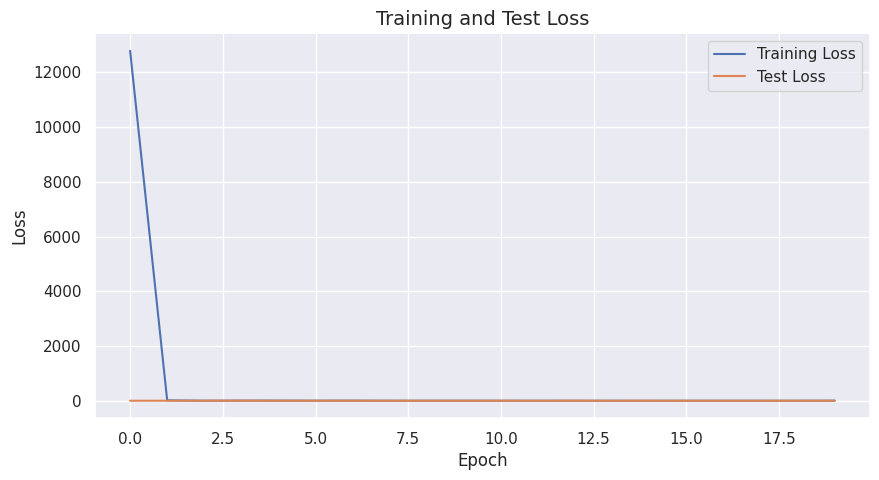

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Seaborn theme
sns.set_theme(style="darkgrid")

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')

# Add title and labels
plt.title('Training and Test Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Add legend
plt.legend()

# Optionally, set the ylim if you want to focus on a specific range of losses
# plt.ylim([0, 10])

# Show the plot
plt.show()

### Spearman rank coefficient

[87.09816742 86.43510437 88.4156723  ... 88.40435028 85.05078888
 45.30361176]


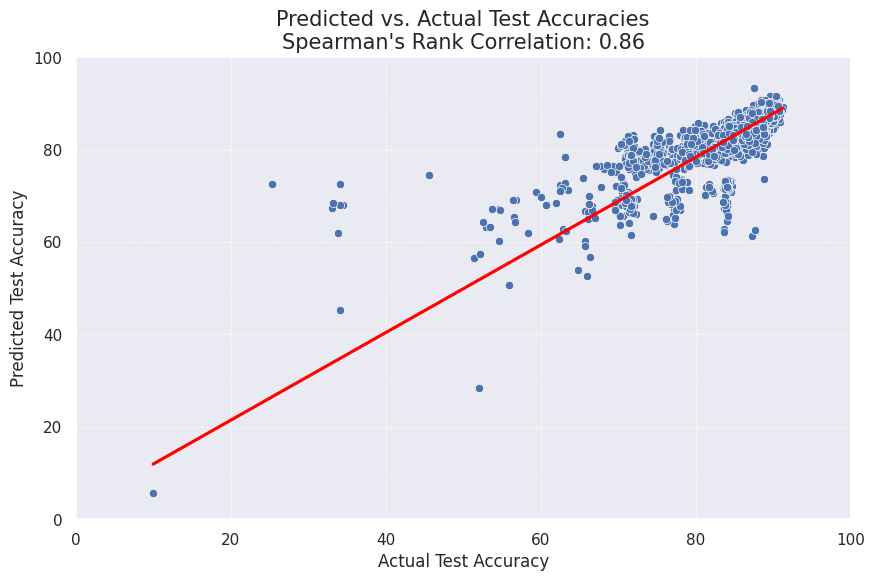

In [ ]:
model.eval()  # Set the model to evaluation mode
predicted_accuracies = []
actual_accuracies = []

with torch.no_grad():  # No need to track gradients
    for i in range(len(inputs_test)):  # Assuming you want to use all test inputs
        predicted_accuracy = model(inputs_test[i].unsqueeze(0))  # Add batch dimension
        predicted_accuracies.append(predicted_accuracy.item())
        actual_accuracies.append(targets_test[i].item())
        
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Assuming predicted_accuracies and actual_accuracies are available
predicted_accuracies_np = np.array(predicted_accuracies)
actual_accuracies_np = np.array(actual_accuracies)

print(predicted_accuracies_np)

# Calculate Spearman's rank correlation
spearman_corr, _ = spearmanr(predicted_accuracies_np, actual_accuracies_np)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Generate a scatter plot
sns.scatterplot(x=actual_accuracies_np, y=predicted_accuracies_np)

# Beautify the plot
plt.title(f'Predicted vs. Actual Test Accuracies\nSpearman\'s Rank Correlation: {spearman_corr:.2f}', fontsize=15)
plt.xlabel('Actual Test Accuracy', fontsize=12)
plt.ylabel('Predicted Test Accuracy', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Optional: Plot a line of best fit
sns.regplot(x=actual_accuracies_np, y=predicted_accuracies_np, scatter=False, ci=None, color="red")
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.show()

### Hyperparameter Tuner

In [39]:
import torch
from torch.utils.data import Dataset, DataLoader

train_dataset = CustomDataset(inputs_train, targets_train, use_percentage= 1)
test_dataset = CustomDataset(inputs_test, targets_test, use_percentage = 1)

In [39]:
import optuna
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

class DynamicModel(nn.Module):
    def __init__(self, input_size, num_layers, hidden_units, output_size):
        super(DynamicModel, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            in_features = input_size if i == 0 else hidden_units
            self.layers.append(nn.Linear(in_features, hidden_units))
        self.final = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        return self.final(x)

def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_units = trial.suggest_int('hidden_units', 5, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop'])
    loss_function = trial.suggest_categorical('loss_function', ['L1', 'MSE', 'SmoothL1'])

    model = DynamicModel(13, num_layers, hidden_units, 1)
    optimizer = {"Adam": optim.Adam, "RMSprop": optim.RMSprop}[optimizer_name](model.parameters(), lr=lr)
    criterion = {"L1": nn.L1Loss(), "MSE": nn.MSELoss(), "SmoothL1": nn.SmoothL1Loss()}[loss_function]

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.train()
    for epoch in range(20):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        # Make sure the print statement is visible
        print(f'=== Epoch {epoch+1} === Loss: {epoch_loss:.4f}')

    model.eval()
    criterion2 = nn.L1Loss()
    total_loss = 0.0
    n_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion2(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            n_samples += inputs.size(0)
    avg_loss = total_loss / n_samples

    # Here, save the best model state dict to the trial
    trial.set_user_attr('best_model_state', model.state_dict())

    return avg_loss

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)

# Retrieve and save the best model state
best_model_state = study.best_trials[-1].user_attrs['best_model_state']
torch.save(best_model_state, 'best_model.pth')

# Load the best model for prediction
model = DynamicModel(13, study.best_trial.params['num_layers'], study.best_trial.params['hidden_units'], 1)
model.load_state_dict(torch.load('saved_models/best_model.pth'))

print('Best trial (minimizing selected loss function):')
print(f'Value (Loss): {study.best_trial.value}')
print('Params: ')
for key, value in study.best_trial.params.items():
    print(f'{key}: {value}')


[I 2024-03-16 21:31:57,602] A new study created in memory with name: no-name-6c8a9ec3-86e4-4943-8173-2c0919f441a2
/var/folders/st/2r570j6x26l43xlczjpfdy7m0000gn/T/ipykernel_41476/3402095913.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


=== Epoch 1 === Loss: 1861487804619.0415
=== Epoch 2 === Loss: 27278512112.6810
=== Epoch 3 === Loss: 186939030.8277
=== Epoch 4 === Loss: 290508957.2220
=== Epoch 5 === Loss: 46099147.9964
=== Epoch 6 === Loss: 34649845.4930
=== Epoch 7 === Loss: 13135824.8268
=== Epoch 8 === Loss: 6386003.9695
=== Epoch 9 === Loss: 3734291.4205
=== Epoch 10 === Loss: 3486614.0780
=== Epoch 11 === Loss: 4682217.0475
=== Epoch 12 === Loss: 9173438.9630
=== Epoch 13 === Loss: 40918582944.4807
=== Epoch 14 === Loss: 48152127.4819
=== Epoch 15 === Loss: 322334698.7801
=== Epoch 16 === Loss: 423518539.0533
=== Epoch 17 === Loss: 1848230.3884
=== Epoch 18 === Loss: 42330.1272


[I 2024-03-16 21:31:58,917] Trial 0 finished with value: 20509.924143125 and parameters: {'lr': 0.05065600749039844, 'batch_size': 128, 'num_layers': 1, 'hidden_units': 64}. Best is trial 0 with value: 20509.924143125.


=== Epoch 19 === Loss: 24128.7778
=== Epoch 20 === Loss: 17837.6539
=== Epoch 1 === Loss: 1302775209922.6213
=== Epoch 2 === Loss: 241261110.5543
=== Epoch 3 === Loss: 10087102.1486
=== Epoch 4 === Loss: 5232411.3006
=== Epoch 5 === Loss: 550246799.5683
=== Epoch 6 === Loss: 497389602.6258
=== Epoch 7 === Loss: 8923480879.8349
=== Epoch 8 === Loss: 4637421829.3993
=== Epoch 9 === Loss: 579131720.6463
=== Epoch 10 === Loss: 1909187150.8930
=== Epoch 11 === Loss: 2226193.2541
=== Epoch 12 === Loss: 864735.0490
=== Epoch 13 === Loss: 807756.6543
=== Epoch 14 === Loss: 267360.4791
=== Epoch 15 === Loss: 129628.9369
=== Epoch 16 === Loss: 74790.3047
=== Epoch 17 === Loss: 53170.6857
=== Epoch 18 === Loss: 46640.9675


[I 2024-03-16 21:32:00,085] Trial 1 finished with value: 10480.465851875 and parameters: {'lr': 0.046201811762831, 'batch_size': 128, 'num_layers': 1, 'hidden_units': 64}. Best is trial 1 with value: 10480.465851875.


=== Epoch 19 === Loss: 35240.8394
=== Epoch 20 === Loss: 43319.8269
=== Epoch 1 === Loss: 837341843.9693
=== Epoch 2 === Loss: 105939.8132
=== Epoch 3 === Loss: 5015570.8866
=== Epoch 4 === Loss: 34478755.2928
=== Epoch 5 === Loss: 81670400.0460
=== Epoch 6 === Loss: 2327770.1194
=== Epoch 7 === Loss: 5699.1323
=== Epoch 8 === Loss: 1032.6670
=== Epoch 9 === Loss: 3995.1366
=== Epoch 10 === Loss: 152544.1879
=== Epoch 11 === Loss: 21133420.7560
=== Epoch 12 === Loss: 974031.7601
=== Epoch 13 === Loss: 6377.8663
=== Epoch 14 === Loss: 812156.4919
=== Epoch 15 === Loss: 52782.0932
=== Epoch 16 === Loss: 4227.7186
=== Epoch 17 === Loss: 565.5746
=== Epoch 18 === Loss: 92821.9653
=== Epoch 19 === Loss: 13544046.5280


[I 2024-03-16 21:32:02,174] Trial 2 finished with value: 4795.100780751953 and parameters: {'lr': 0.0023973954986912177, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 2 with value: 4795.100780751953.


=== Epoch 20 === Loss: 217781.7952
=== Epoch 1 === Loss: 10111762131.2808
=== Epoch 2 === Loss: 8143510439.5656
=== Epoch 3 === Loss: 6599112576.9272
=== Epoch 4 === Loss: 5369841281.2118
=== Epoch 5 === Loss: 4536835551.0226
=== Epoch 6 === Loss: 3914048976.4078
=== Epoch 7 === Loss: 3372177234.8148
=== Epoch 8 === Loss: 2902747262.3952
=== Epoch 9 === Loss: 2495573610.8967
=== Epoch 10 === Loss: 2148235100.3653
=== Epoch 11 === Loss: 1846766043.4851
=== Epoch 12 === Loss: 1580791775.5526
=== Epoch 13 === Loss: 1350091930.2122
=== Epoch 14 === Loss: 1151013339.7380
=== Epoch 15 === Loss: 977625583.0613
=== Epoch 16 === Loss: 828813633.8772
=== Epoch 17 === Loss: 699751098.0388
=== Epoch 18 === Loss: 587923753.8766


[I 2024-03-16 21:32:05,682] Trial 3 finished with value: 262705492.99949095 and parameters: {'lr': 1.605594135358953e-05, 'batch_size': 32, 'num_layers': 3, 'hidden_units': 8}. Best is trial 2 with value: 4795.100780751953.


=== Epoch 19 === Loss: 491909901.2078
=== Epoch 20 === Loss: 410006259.8802
=== Epoch 1 === Loss: 4235595091255.6499
=== Epoch 2 === Loss: 852159425760.2352
=== Epoch 3 === Loss: 152837096217.5428
=== Epoch 4 === Loss: 65837829831.0208
=== Epoch 5 === Loss: 41968070981.4631
=== Epoch 6 === Loss: 25959965018.3351
=== Epoch 7 === Loss: 15216812889.5610
=== Epoch 8 === Loss: 8350405552.2610
=== Epoch 9 === Loss: 4370789819.1852
=== Epoch 10 === Loss: 2131323069.5584
=== Epoch 11 === Loss: 989300431.5608
=== Epoch 12 === Loss: 424183246.8577
=== Epoch 13 === Loss: 173541012.0904
=== Epoch 14 === Loss: 65535109.2668
=== Epoch 15 === Loss: 22995548.7305
=== Epoch 16 === Loss: 7817504.6151


[I 2024-03-16 21:32:06,833] Trial 4 finished with value: 107146.60546 and parameters: {'lr': 0.00014402727086891182, 'batch_size': 128, 'num_layers': 1, 'hidden_units': 16}. Best is trial 2 with value: 4795.100780751953.


=== Epoch 17 === Loss: 2536848.8876
=== Epoch 18 === Loss: 761788.0688
=== Epoch 19 === Loss: 254721.4583
=== Epoch 20 === Loss: 117836.1450
=== Epoch 1 === Loss: 2716114883.5527
=== Epoch 2 === Loss: 672.3242
=== Epoch 3 === Loss: 480.9592
=== Epoch 4 === Loss: 305.4944
=== Epoch 5 === Loss: 231.2649
=== Epoch 6 === Loss: 171.2784
=== Epoch 7 === Loss: 121.8469
=== Epoch 8 === Loss: 98.1104
=== Epoch 9 === Loss: 30.5346
=== Epoch 10 === Loss: 856.4762
=== Epoch 11 === Loss: 56987650.7726
=== Epoch 12 === Loss: 712.2095
=== Epoch 13 === Loss: 25.2206
=== Epoch 14 === Loss: 22.6096
=== Epoch 15 === Loss: 55.2909
=== Epoch 16 === Loss: 1257509.8410
=== Epoch 17 === Loss: 51474571.5326
=== Epoch 18 === Loss: 59.0694


[I 2024-03-16 21:32:10,304] Trial 5 finished with value: 2085002.5331232226 and parameters: {'lr': 0.000821781359061689, 'batch_size': 32, 'num_layers': 3, 'hidden_units': 8}. Best is trial 2 with value: 4795.100780751953.


=== Epoch 19 === Loss: 54.6337
=== Epoch 20 === Loss: 340185.2598
=== Epoch 1 === Loss: 1039023265.9937
=== Epoch 2 === Loss: 21639170.3663
=== Epoch 3 === Loss: 131125138.8048
=== Epoch 4 === Loss: 340153077.3143
=== Epoch 5 === Loss: 45758.4534
=== Epoch 6 === Loss: 174791.3500
=== Epoch 7 === Loss: 98395069.6304
=== Epoch 8 === Loss: 118515.6131
=== Epoch 9 === Loss: 446096.1396
=== Epoch 10 === Loss: 61176489.2047
=== Epoch 11 === Loss: 30071177.3762
=== Epoch 12 === Loss: 22963.8543
=== Epoch 13 === Loss: 96880.2994
=== Epoch 14 === Loss: 7864380.2673
=== Epoch 15 === Loss: 4380866.2299
=== Epoch 16 === Loss: 16461663.9741
=== Epoch 17 === Loss: 6333892.4830
=== Epoch 18 === Loss: 42565813.5672
=== Epoch 19 === Loss: 13873.4416


[I 2024-03-16 21:32:14,227] Trial 6 finished with value: 2430.7074409985353 and parameters: {'lr': 0.000445447401556128, 'batch_size': 32, 'num_layers': 3, 'hidden_units': 64}. Best is trial 6 with value: 2430.7074409985353.


=== Epoch 20 === Loss: 23288.4711
=== Epoch 1 === Loss: 31804475440.9995
=== Epoch 2 === Loss: 3779073.2800
=== Epoch 3 === Loss: 26730.5337
=== Epoch 4 === Loss: 1105109.6243
=== Epoch 5 === Loss: 149327964.0269
=== Epoch 6 === Loss: 107479455.1802
=== Epoch 7 === Loss: 933332885.1191
=== Epoch 8 === Loss: 996163277.7431
=== Epoch 9 === Loss: 29137833.2572
=== Epoch 10 === Loss: 45455830.8046
=== Epoch 11 === Loss: 1611974173.2823
=== Epoch 12 === Loss: 4051466561.4700
=== Epoch 13 === Loss: 1367957062.1504
=== Epoch 14 === Loss: 213071958.2291
=== Epoch 15 === Loss: 1863214799.1168
=== Epoch 16 === Loss: 490455031.8124
=== Epoch 17 === Loss: 10330420.3827
=== Epoch 18 === Loss: 11950405.7796
=== Epoch 19 === Loss: 219150.8966


[I 2024-03-16 21:32:15,325] Trial 7 finished with value: 805870.685068125 and parameters: {'lr': 0.004968203643460623, 'batch_size': 128, 'num_layers': 1, 'hidden_units': 32}. Best is trial 6 with value: 2430.7074409985353.


=== Epoch 20 === Loss: 1159287.1561
=== Epoch 1 === Loss: 6322687647.2894
=== Epoch 2 === Loss: 209598.7156
=== Epoch 3 === Loss: 1498588334.2270
=== Epoch 4 === Loss: 27099.0752
=== Epoch 5 === Loss: 71778.1393
=== Epoch 6 === Loss: 2032.5239
=== Epoch 7 === Loss: 156.4893
=== Epoch 8 === Loss: 62.0285
=== Epoch 9 === Loss: 54.2435
=== Epoch 10 === Loss: 126.2157
=== Epoch 11 === Loss: 141.8269
=== Epoch 12 === Loss: 82.9473
=== Epoch 13 === Loss: 68.4971
=== Epoch 14 === Loss: 57.2587
=== Epoch 15 === Loss: 57.3149
=== Epoch 16 === Loss: 41.3075
=== Epoch 17 === Loss: 33.7911
=== Epoch 18 === Loss: 31.6486


[I 2024-03-16 21:32:18,556] Trial 8 finished with value: 28.058759296264647 and parameters: {'lr': 0.011361963305835639, 'batch_size': 32, 'num_layers': 2, 'hidden_units': 16}. Best is trial 8 with value: 28.058759296264647.


=== Epoch 19 === Loss: 31.7229
=== Epoch 20 === Loss: 45.8921
=== Epoch 1 === Loss: 4770306637223.8525
=== Epoch 2 === Loss: 1289415555893.0662
=== Epoch 3 === Loss: 278354667842.0286
=== Epoch 4 === Loss: 64504187106.7835
=== Epoch 5 === Loss: 24086647321.8315
=== Epoch 6 === Loss: 10558516971.7175
=== Epoch 7 === Loss: 4226313062.1774
=== Epoch 8 === Loss: 1454047935.3523
=== Epoch 9 === Loss: 413894684.5772
=== Epoch 10 === Loss: 93220850.2570
=== Epoch 11 === Loss: 16862844.9133
=== Epoch 12 === Loss: 3948480.2370
=== Epoch 13 === Loss: 2384666.2609
=== Epoch 14 === Loss: 2141334.2601
=== Epoch 15 === Loss: 1995516.4581
=== Epoch 16 === Loss: 1865104.0426
=== Epoch 17 === Loss: 1724654.1563
=== Epoch 18 === Loss: 1586703.8419


[I 2024-03-16 21:32:21,007] Trial 9 finished with value: 16337.97700765625 and parameters: {'lr': 6.450165430954849e-05, 'batch_size': 32, 'num_layers': 1, 'hidden_units': 16}. Best is trial 8 with value: 28.058759296264647.


=== Epoch 19 === Loss: 1449325.4900
=== Epoch 20 === Loss: 1331891.8121
=== Epoch 1 === Loss: 17883202946.2281
=== Epoch 2 === Loss: 220395.5758
=== Epoch 3 === Loss: 1542251.9163
=== Epoch 4 === Loss: 2372656496.5069
=== Epoch 5 === Loss: 167.7691
=== Epoch 6 === Loss: 946.1963
=== Epoch 7 === Loss: 17958798.5852
=== Epoch 8 === Loss: 40052.3587
=== Epoch 9 === Loss: 41856.2650
=== Epoch 10 === Loss: 20312.9749
=== Epoch 11 === Loss: 16224.4449
=== Epoch 12 === Loss: 4515.0843
=== Epoch 13 === Loss: 1285.3726
=== Epoch 14 === Loss: 407.0572
=== Epoch 15 === Loss: 145.2901
=== Epoch 16 === Loss: 181.7327
=== Epoch 17 === Loss: 42.5732
=== Epoch 18 === Loss: 62.2832
=== Epoch 19 === Loss: 56.0457


[I 2024-03-16 21:32:26,262] Trial 10 finished with value: 32.95917542297363 and parameters: {'lr': 0.00848288613160803, 'batch_size': 16, 'num_layers': 2, 'hidden_units': 16}. Best is trial 8 with value: 28.058759296264647.


=== Epoch 20 === Loss: 46.4520
=== Epoch 1 === Loss: 9167876497.3239
=== Epoch 2 === Loss: 250250.6341
=== Epoch 3 === Loss: 7445.2867
=== Epoch 4 === Loss: 6408.1208
=== Epoch 5 === Loss: 642.8443
=== Epoch 6 === Loss: 5677.1138
=== Epoch 7 === Loss: 148312.5589
=== Epoch 8 === Loss: 4080.9442
=== Epoch 9 === Loss: 2879538242.2053
=== Epoch 10 === Loss: 299.6496
=== Epoch 11 === Loss: 220.2509
=== Epoch 12 === Loss: 207.5341
=== Epoch 13 === Loss: 182.5718
=== Epoch 14 === Loss: 169.1992
=== Epoch 15 === Loss: 176.9975
=== Epoch 16 === Loss: 176.0654
=== Epoch 17 === Loss: 128.9921
=== Epoch 18 === Loss: 151.5029
=== Epoch 19 === Loss: 276.9509


[I 2024-03-16 21:32:31,647] Trial 11 finished with value: 160.23957357788086 and parameters: {'lr': 0.011514698837684245, 'batch_size': 16, 'num_layers': 2, 'hidden_units': 16}. Best is trial 8 with value: 28.058759296264647.


=== Epoch 20 === Loss: 165.2454
=== Epoch 1 === Loss: 6802893250.1809
=== Epoch 2 === Loss: 4933465.5559
=== Epoch 3 === Loss: 168575.9345
=== Epoch 4 === Loss: 88979.0537
=== Epoch 5 === Loss: 36072.3557
=== Epoch 6 === Loss: 725333.0864
=== Epoch 7 === Loss: 8215.3591
=== Epoch 8 === Loss: 4310300.3877
=== Epoch 9 === Loss: 312.9717
=== Epoch 10 === Loss: 284.2535
=== Epoch 11 === Loss: 266.6720
=== Epoch 12 === Loss: 15520.4391
=== Epoch 13 === Loss: 29942.2839
=== Epoch 14 === Loss: 79419.2084
=== Epoch 15 === Loss: 226.0776
=== Epoch 16 === Loss: 217.4802
=== Epoch 17 === Loss: 230.5076
=== Epoch 18 === Loss: 209.4389
=== Epoch 19 === Loss: 208.4416


[I 2024-03-16 21:32:37,048] Trial 12 finished with value: 222.53419651245116 and parameters: {'lr': 0.011562259135312456, 'batch_size': 16, 'num_layers': 2, 'hidden_units': 16}. Best is trial 8 with value: 28.058759296264647.


=== Epoch 20 === Loss: 190.2622
=== Epoch 1 === Loss: 2299679381.8791
=== Epoch 2 === Loss: 192334371.3734
=== Epoch 3 === Loss: 22496.0004
=== Epoch 4 === Loss: 271237.3543
=== Epoch 5 === Loss: 339.9922
=== Epoch 6 === Loss: 1188.5981
=== Epoch 7 === Loss: 285.9861
=== Epoch 8 === Loss: 270.4658
=== Epoch 9 === Loss: 257.3844
=== Epoch 10 === Loss: 242.3502
=== Epoch 11 === Loss: 227.7997
=== Epoch 12 === Loss: 210.3762
=== Epoch 13 === Loss: 189.5651
=== Epoch 14 === Loss: 163.9563
=== Epoch 15 === Loss: 141.2747
=== Epoch 16 === Loss: 211.2507
=== Epoch 17 === Loss: 133.9369
=== Epoch 18 === Loss: 98.0520
=== Epoch 19 === Loss: 90.7288


[I 2024-03-16 21:32:42,442] Trial 13 finished with value: 2055.010710581055 and parameters: {'lr': 0.016245724492268878, 'batch_size': 16, 'num_layers': 2, 'hidden_units': 16}. Best is trial 8 with value: 28.058759296264647.


=== Epoch 20 === Loss: 5030.4912
=== Epoch 1 === Loss: 147686589160.4205
=== Epoch 2 === Loss: 23387.6785
=== Epoch 3 === Loss: 9600.0777
=== Epoch 4 === Loss: 289307.2223
=== Epoch 5 === Loss: 129898.1248
=== Epoch 6 === Loss: 1398.6773
=== Epoch 7 === Loss: 1284.0903
=== Epoch 8 === Loss: 2807.4239
=== Epoch 9 === Loss: 8375.8597
=== Epoch 10 === Loss: 710073.6874
=== Epoch 11 === Loss: 92336635.8977
=== Epoch 12 === Loss: 165327467.2505
=== Epoch 13 === Loss: 46972.9446
=== Epoch 14 === Loss: 281.2315
=== Epoch 15 === Loss: 299.7035
=== Epoch 16 === Loss: 330.1853
=== Epoch 17 === Loss: 507.9087


[I 2024-03-16 21:32:44,220] Trial 14 finished with value: 1199.2769055273438 and parameters: {'lr': 0.0027406794546165217, 'batch_size': 64, 'num_layers': 2, 'hidden_units': 16}. Best is trial 8 with value: 28.058759296264647.


=== Epoch 18 === Loss: 1165.9830
=== Epoch 19 === Loss: 4029.0572
=== Epoch 20 === Loss: 10794.1480
=== Epoch 1 === Loss: 4222132567.7570
=== Epoch 2 === Loss: 6630.1868
=== Epoch 3 === Loss: 5933.5234
=== Epoch 4 === Loss: 5552.0327
=== Epoch 5 === Loss: 5176.3424
=== Epoch 6 === Loss: 4966.8128
=== Epoch 7 === Loss: 2989.2582
=== Epoch 8 === Loss: 1079.1840
=== Epoch 9 === Loss: 763.3354
=== Epoch 10 === Loss: 610.3161
=== Epoch 11 === Loss: 597.0488
=== Epoch 12 === Loss: 474.4153
=== Epoch 13 === Loss: 770.1038
=== Epoch 14 === Loss: 1702.4591
=== Epoch 15 === Loss: 1133.5877
=== Epoch 16 === Loss: 265.6410
=== Epoch 17 === Loss: 170.9428
=== Epoch 18 === Loss: 167.1382
=== Epoch 19 === Loss: 167.1117


[I 2024-03-16 21:32:49,561] Trial 15 finished with value: 143.09323886230467 and parameters: {'lr': 0.07683332618632342, 'batch_size': 16, 'num_layers': 2, 'hidden_units': 16}. Best is trial 8 with value: 28.058759296264647.


=== Epoch 20 === Loss: 167.1138
=== Epoch 1 === Loss: 6493025449.7187
=== Epoch 2 === Loss: 28576.6335
=== Epoch 3 === Loss: 1204899.7606
=== Epoch 4 === Loss: 1199.7383
=== Epoch 5 === Loss: 1078.5488
=== Epoch 6 === Loss: 82210091655.5738
=== Epoch 7 === Loss: 14667.2678
=== Epoch 8 === Loss: 13348.7997
=== Epoch 9 === Loss: 12286.1971
=== Epoch 10 === Loss: 11431.7498
=== Epoch 11 === Loss: 10696.2481
=== Epoch 12 === Loss: 10027.4055
=== Epoch 13 === Loss: 9418.8017
=== Epoch 14 === Loss: 8841.0870
=== Epoch 15 === Loss: 8305.7056
=== Epoch 16 === Loss: 7784.8753
=== Epoch 17 === Loss: 7278.9099
=== Epoch 18 === Loss: 6788.3269
=== Epoch 19 === Loss: 6284.3849


[I 2024-03-16 21:32:52,535] Trial 16 finished with value: 12782.74379647461 and parameters: {'lr': 0.019815538194827086, 'batch_size': 32, 'num_layers': 2, 'hidden_units': 16}. Best is trial 8 with value: 28.058759296264647.


=== Epoch 20 === Loss: 5794.5257
=== Epoch 1 === Loss: 3823843463.2840
=== Epoch 2 === Loss: 30932.0588
=== Epoch 3 === Loss: 5405509713.1538
=== Epoch 4 === Loss: 363083.5711
=== Epoch 5 === Loss: 21658.2255
=== Epoch 6 === Loss: 6701.1217
=== Epoch 7 === Loss: 1531.1721
=== Epoch 8 === Loss: 531.5352
=== Epoch 9 === Loss: 355.3850
=== Epoch 10 === Loss: 302.6661
=== Epoch 11 === Loss: 294.2317
=== Epoch 12 === Loss: 290.6834
=== Epoch 13 === Loss: 290.0235
=== Epoch 14 === Loss: 293.9220
=== Epoch 15 === Loss: 278.6375
=== Epoch 16 === Loss: 274.4947
=== Epoch 17 === Loss: 283.2434
=== Epoch 18 === Loss: 21752.5046
=== Epoch 19 === Loss: 917.8383


[I 2024-03-16 21:32:57,796] Trial 17 finished with value: 42.728891552734375 and parameters: {'lr': 0.0035521469478215053, 'batch_size': 16, 'num_layers': 2, 'hidden_units': 8}. Best is trial 8 with value: 28.058759296264647.


=== Epoch 20 === Loss: 15789.4473
=== Epoch 1 === Loss: 687251040.3115
=== Epoch 2 === Loss: 774277.9018
=== Epoch 3 === Loss: 36604059.8128
=== Epoch 4 === Loss: 429786344.5757
=== Epoch 5 === Loss: 89179780.9475
=== Epoch 6 === Loss: 42246.4088
=== Epoch 7 === Loss: 5244.6570
=== Epoch 8 === Loss: 1000.2652
=== Epoch 9 === Loss: 928.4923
=== Epoch 10 === Loss: 1105.4718
=== Epoch 11 === Loss: 1439.1167
=== Epoch 12 === Loss: 15828.0289
=== Epoch 13 === Loss: 718954.6065
=== Epoch 14 === Loss: 321032786.5582
=== Epoch 15 === Loss: 23004.1210
=== Epoch 16 === Loss: 57.9123
=== Epoch 17 === Loss: 62.7606
=== Epoch 18 === Loss: 48.9051
=== Epoch 19 === Loss: 20.8998


[I 2024-03-16 21:32:59,880] Trial 18 finished with value: 23.77511182800293 and parameters: {'lr': 0.0007839735962018706, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 18 with value: 23.77511182800293.


=== Epoch 20 === Loss: 20.6453
=== Epoch 1 === Loss: 1260742425.2449
=== Epoch 2 === Loss: 398.7685
=== Epoch 3 === Loss: 320.5567
=== Epoch 4 === Loss: 539.4524
=== Epoch 5 === Loss: 623.8117
=== Epoch 6 === Loss: 954.4758
=== Epoch 7 === Loss: 2097.3183
=== Epoch 8 === Loss: 2599.4620
=== Epoch 9 === Loss: 2920.7136
=== Epoch 10 === Loss: 1567.0429
=== Epoch 11 === Loss: 1238.8399
=== Epoch 12 === Loss: 413.1939
=== Epoch 13 === Loss: 852.5344
=== Epoch 14 === Loss: 1456.4278
=== Epoch 15 === Loss: 3821.7794
=== Epoch 16 === Loss: 50890183.5611
=== Epoch 17 === Loss: 174861932.3932
=== Epoch 18 === Loss: 6733625.1379
=== Epoch 19 === Loss: 249784.8877


[I 2024-03-16 21:33:01,988] Trial 19 finished with value: 1447.8814343457032 and parameters: {'lr': 0.0002946274597357467, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 18 with value: 23.77511182800293.


=== Epoch 20 === Loss: 7414.4344
=== Epoch 1 === Loss: 4170183427.1413
=== Epoch 2 === Loss: 638.3192
=== Epoch 3 === Loss: 169.9360
=== Epoch 4 === Loss: 45849.9063
=== Epoch 5 === Loss: 55169.1176
=== Epoch 6 === Loss: 985.3442
=== Epoch 7 === Loss: 2959.4475
=== Epoch 8 === Loss: 29491.3319
=== Epoch 9 === Loss: 433638.1893
=== Epoch 10 === Loss: 630086.7872
=== Epoch 11 === Loss: 12437424.2012
=== Epoch 12 === Loss: 195356360.7293
=== Epoch 13 === Loss: 4126.9074
=== Epoch 14 === Loss: 1605.8000
=== Epoch 15 === Loss: 2113.1337
=== Epoch 16 === Loss: 2963.5014
=== Epoch 17 === Loss: 3052.8892
=== Epoch 18 === Loss: 2849.7472


[I 2024-03-16 21:33:04,061] Trial 20 finished with value: 1005630.4539633204 and parameters: {'lr': 0.0010321242506037894, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 18 with value: 23.77511182800293.


=== Epoch 19 === Loss: 3251034.5141
=== Epoch 20 === Loss: 8426590.1376
=== Epoch 1 === Loss: 4419404460.9698
=== Epoch 2 === Loss: 86568046.6322
=== Epoch 3 === Loss: 11898.0319
=== Epoch 4 === Loss: 38071.3941
=== Epoch 5 === Loss: 60978.0293
=== Epoch 6 === Loss: 380340.1273
=== Epoch 7 === Loss: 1231537.4942
=== Epoch 8 === Loss: 122970.8753
=== Epoch 9 === Loss: 6627.5766
=== Epoch 10 === Loss: 1825.1843
=== Epoch 11 === Loss: 406.0903
=== Epoch 12 === Loss: 7784.8711
=== Epoch 13 === Loss: 12112.6490
=== Epoch 14 === Loss: 657.9146
=== Epoch 15 === Loss: 262.5594
=== Epoch 16 === Loss: 201.1043
=== Epoch 17 === Loss: 154764.5577


[I 2024-03-16 21:33:06,134] Trial 21 finished with value: 177.23840184570312 and parameters: {'lr': 0.0064019663897906635, 'batch_size': 64, 'num_layers': 2, 'hidden_units': 32}. Best is trial 18 with value: 23.77511182800293.


=== Epoch 18 === Loss: 37761316.2386
=== Epoch 19 === Loss: 930068.4090
=== Epoch 20 === Loss: 3123.8008
=== Epoch 1 === Loss: 2447843469.2282
=== Epoch 2 === Loss: 273110994.9930
=== Epoch 3 === Loss: 1659944808.4371
=== Epoch 4 === Loss: 324179101.6651
=== Epoch 5 === Loss: 834561.1639
=== Epoch 6 === Loss: 82139117.0758
=== Epoch 7 === Loss: 1667920.3664
=== Epoch 8 === Loss: 157058775.5072
=== Epoch 9 === Loss: 31254530.2710
=== Epoch 10 === Loss: 91080621.0390
=== Epoch 11 === Loss: 507081740.8196
=== Epoch 12 === Loss: 541641594.7101
=== Epoch 13 === Loss: 152460.8336
=== Epoch 14 === Loss: 17168.4735
=== Epoch 15 === Loss: 4933.8785
=== Epoch 16 === Loss: 2466.4768
=== Epoch 17 === Loss: 1714.1783
=== Epoch 18 === Loss: 56246.4664


[I 2024-03-16 21:33:07,997] Trial 22 finished with value: 267.32284482421875 and parameters: {'lr': 0.0017444479958132857, 'batch_size': 64, 'num_layers': 2, 'hidden_units': 32}. Best is trial 18 with value: 23.77511182800293.


=== Epoch 19 === Loss: 481603018.6808
=== Epoch 20 === Loss: 337813865.4416
=== Epoch 1 === Loss: 24899453573.8806
=== Epoch 2 === Loss: 72.3589
=== Epoch 3 === Loss: 50673.0439
=== Epoch 4 === Loss: 87.8618
=== Epoch 5 === Loss: 64.5071
=== Epoch 6 === Loss: 44.3818
=== Epoch 7 === Loss: 57.7730
=== Epoch 8 === Loss: 33.6099
=== Epoch 9 === Loss: 225.6044
=== Epoch 10 === Loss: 785716.7773
=== Epoch 11 === Loss: 65.7405
=== Epoch 12 === Loss: 48.7588
=== Epoch 13 === Loss: 109122.5634
=== Epoch 14 === Loss: 104.5745
=== Epoch 15 === Loss: 101.4997
=== Epoch 16 === Loss: 96.9805
=== Epoch 17 === Loss: 82.4617
=== Epoch 18 === Loss: 88.8441
=== Epoch 19 === Loss: 77.3255


[I 2024-03-16 21:33:14,470] Trial 23 finished with value: 73.12376076782226 and parameters: {'lr': 0.026912189664724393, 'batch_size': 16, 'num_layers': 3, 'hidden_units': 16}. Best is trial 18 with value: 23.77511182800293.


=== Epoch 20 === Loss: 115.0316
=== Epoch 1 === Loss: 2292646489.9054
=== Epoch 2 === Loss: 1413192.1602
=== Epoch 3 === Loss: 2606.4029
=== Epoch 4 === Loss: 1448.5839
=== Epoch 5 === Loss: 413354.5334
=== Epoch 6 === Loss: 469840539.2523
=== Epoch 7 === Loss: 1821773.6856
=== Epoch 8 === Loss: 142851772.2044
=== Epoch 9 === Loss: 89870.7633
=== Epoch 10 === Loss: 7177286.1312
=== Epoch 11 === Loss: 956557197.2996
=== Epoch 12 === Loss: 35601698.0870
=== Epoch 13 === Loss: 7270.9704
=== Epoch 14 === Loss: 84220.7225
=== Epoch 15 === Loss: 38282.4504
=== Epoch 16 === Loss: 5270.3260
=== Epoch 17 === Loss: 119403.7362
=== Epoch 18 === Loss: 195859220.3836
=== Epoch 19 === Loss: 90.3342


[I 2024-03-16 21:33:17,539] Trial 24 finished with value: 73.43124162597657 and parameters: {'lr': 0.00106628974304957, 'batch_size': 32, 'num_layers': 2, 'hidden_units': 16}. Best is trial 18 with value: 23.77511182800293.


=== Epoch 20 === Loss: 1167.6536
=== Epoch 1 === Loss: 5830853724.2690
=== Epoch 2 === Loss: 1939835.3016
=== Epoch 3 === Loss: 7756590.1898
=== Epoch 4 === Loss: 42.6447
=== Epoch 5 === Loss: 27356.2620
=== Epoch 6 === Loss: 398933596.4346
=== Epoch 7 === Loss: 92.9137
=== Epoch 8 === Loss: 45.9436
=== Epoch 9 === Loss: 35.0801
=== Epoch 10 === Loss: 33.3995
=== Epoch 11 === Loss: 29.5794
=== Epoch 12 === Loss: 32.4558
=== Epoch 13 === Loss: 1171.8657
=== Epoch 14 === Loss: 44.1823
=== Epoch 15 === Loss: 40.3691
=== Epoch 16 === Loss: 33.3969
=== Epoch 17 === Loss: 30.2319
=== Epoch 18 === Loss: 28.7613
=== Epoch 19 === Loss: 29.2980


[I 2024-03-16 21:33:20,617] Trial 25 finished with value: 28.057074078979493 and parameters: {'lr': 0.008001406799834361, 'batch_size': 32, 'num_layers': 2, 'hidden_units': 32}. Best is trial 18 with value: 23.77511182800293.


=== Epoch 20 === Loss: 31.6449
=== Epoch 1 === Loss: 505909741.4261
=== Epoch 2 === Loss: 11668.4400
=== Epoch 3 === Loss: 22288.3482
=== Epoch 4 === Loss: 82250.2068
=== Epoch 5 === Loss: 232.9015
=== Epoch 6 === Loss: 14284773.4064
=== Epoch 7 === Loss: 7349060.2768
=== Epoch 8 === Loss: 12369.0119
=== Epoch 9 === Loss: 99632774.5920
=== Epoch 10 === Loss: 3339.9315
=== Epoch 11 === Loss: 4453.2622
=== Epoch 12 === Loss: 25702.6085
=== Epoch 13 === Loss: 1440.0113
=== Epoch 14 === Loss: 15172.6124
=== Epoch 15 === Loss: 60360760.2321
=== Epoch 16 === Loss: 2954176.5559
=== Epoch 17 === Loss: 308.1395
=== Epoch 18 === Loss: 1215.6458


[I 2024-03-16 21:33:24,245] Trial 26 finished with value: 74487196.33598523 and parameters: {'lr': 0.0001914561653605946, 'batch_size': 32, 'num_layers': 3, 'hidden_units': 32}. Best is trial 18 with value: 23.77511182800293.


=== Epoch 19 === Loss: 10504.3915
=== Epoch 20 === Loss: 466756.6988
=== Epoch 1 === Loss: 3445924785.6241
=== Epoch 2 === Loss: 53849.4626
=== Epoch 3 === Loss: 2191.5551
=== Epoch 4 === Loss: 1547.8250
=== Epoch 5 === Loss: 2255.2489
=== Epoch 6 === Loss: 3456.8486
=== Epoch 7 === Loss: 1906.2621
=== Epoch 8 === Loss: 1136.0680
=== Epoch 9 === Loss: 934.5759
=== Epoch 10 === Loss: 2429.6554
=== Epoch 11 === Loss: 897.0684
=== Epoch 12 === Loss: 845.0063
=== Epoch 13 === Loss: 6548.1034
=== Epoch 14 === Loss: 130725.7897
=== Epoch 15 === Loss: 41618205.4012
=== Epoch 16 === Loss: 6765.0407
=== Epoch 17 === Loss: 830.0880
=== Epoch 18 === Loss: 844.4501
=== Epoch 19 === Loss: 615.0543


[I 2024-03-16 21:33:27,406] Trial 27 finished with value: 49.56253441955566 and parameters: {'lr': 4.2167777402294636e-05, 'batch_size': 32, 'num_layers': 2, 'hidden_units': 32}. Best is trial 18 with value: 23.77511182800293.


=== Epoch 20 === Loss: 896.4941
=== Epoch 1 === Loss: 159250066.8912
=== Epoch 2 === Loss: 2683.3567
=== Epoch 3 === Loss: 205045.1609
=== Epoch 4 === Loss: 106876095.7599
=== Epoch 5 === Loss: 980.9397
=== Epoch 6 === Loss: 2573.0744
=== Epoch 7 === Loss: 266516.0730
=== Epoch 8 === Loss: 108679465.0892
=== Epoch 9 === Loss: 170287.5050
=== Epoch 10 === Loss: 45.4344
=== Epoch 11 === Loss: 164.2923
=== Epoch 12 === Loss: 465.3560
=== Epoch 13 === Loss: 2500.4479
=== Epoch 14 === Loss: 6104.4601
=== Epoch 15 === Loss: 2004341.1624
=== Epoch 16 === Loss: 6570972.0704
=== Epoch 17 === Loss: 401837.6822
=== Epoch 18 === Loss: 3990161.3964


[I 2024-03-16 21:33:30,934] Trial 28 finished with value: 31.181003060302736 and parameters: {'lr': 0.0005359228371303492, 'batch_size': 32, 'num_layers': 3, 'hidden_units': 32}. Best is trial 18 with value: 23.77511182800293.


=== Epoch 19 === Loss: 14416330.5802
=== Epoch 20 === Loss: 5127.4866
=== Epoch 1 === Loss: 1451493365147.3833
=== Epoch 2 === Loss: 157110371.6413
=== Epoch 3 === Loss: 4581001.1831
=== Epoch 4 === Loss: 3558562088.9083
=== Epoch 5 === Loss: 2278912.3057
=== Epoch 6 === Loss: 961723.7637
=== Epoch 7 === Loss: 48017911.7006
=== Epoch 8 === Loss: 227874716.7635
=== Epoch 9 === Loss: 87753840.3490
=== Epoch 10 === Loss: 342336.5152
=== Epoch 11 === Loss: 13874.5083
=== Epoch 12 === Loss: 23090.5624
=== Epoch 13 === Loss: 90235.1828
=== Epoch 14 === Loss: 126091.5347
=== Epoch 15 === Loss: 257599.8502
=== Epoch 16 === Loss: 2303564.3585
=== Epoch 17 === Loss: 1442313.3937
=== Epoch 18 === Loss: 12183193.4665


[I 2024-03-16 21:33:33,407] Trial 29 finished with value: 17438.7482275 and parameters: {'lr': 0.04391934961566936, 'batch_size': 32, 'num_layers': 1, 'hidden_units': 64}. Best is trial 18 with value: 23.77511182800293.


=== Epoch 19 === Loss: 27483142.7122
=== Epoch 20 === Loss: 133675.9928
=== Epoch 1 === Loss: 59775221154.6599
=== Epoch 2 === Loss: 125519887.0806
=== Epoch 3 === Loss: 4188153.2207
=== Epoch 4 === Loss: 30454453.7728
=== Epoch 5 === Loss: 3764885.9993
=== Epoch 6 === Loss: 5406556.3966
=== Epoch 7 === Loss: 1311175.1910
=== Epoch 8 === Loss: 816990075.5733
=== Epoch 9 === Loss: 226913880.6858
=== Epoch 10 === Loss: 13554966633.7459
=== Epoch 11 === Loss: 2816749.0144
=== Epoch 12 === Loss: 566716.2600
=== Epoch 13 === Loss: 2447986.9389
=== Epoch 14 === Loss: 3620878.3605
=== Epoch 15 === Loss: 26919135.0474
=== Epoch 16 === Loss: 1662439652.6328
=== Epoch 17 === Loss: 9285668505.7086
=== Epoch 18 === Loss: 853158.4890


[I 2024-03-16 21:33:34,942] Trial 30 finished with value: 681.3809368164062 and parameters: {'lr': 0.0050334574100052275, 'batch_size': 64, 'num_layers': 1, 'hidden_units': 32}. Best is trial 18 with value: 23.77511182800293.


=== Epoch 19 === Loss: 796.0381
=== Epoch 20 === Loss: 702.2338
=== Epoch 1 === Loss: 814409465.0974
=== Epoch 2 === Loss: 788.0994
=== Epoch 3 === Loss: 522.6211
=== Epoch 4 === Loss: 74689338.3515
=== Epoch 5 === Loss: 15905958.3173
=== Epoch 6 === Loss: 103989.3965
=== Epoch 7 === Loss: 7116411.7517
=== Epoch 8 === Loss: 57676501.6622
=== Epoch 9 === Loss: 94275.9816
=== Epoch 10 === Loss: 108484.0791
=== Epoch 11 === Loss: 80059370.7751
=== Epoch 12 === Loss: 36492.0876
=== Epoch 13 === Loss: 27.0808
=== Epoch 14 === Loss: 26.7880
=== Epoch 15 === Loss: 26.4975
=== Epoch 16 === Loss: 26.8569
=== Epoch 17 === Loss: 25.9695
=== Epoch 18 === Loss: 26.1188
=== Epoch 19 === Loss: 809120.6210


[I 2024-03-16 21:33:38,643] Trial 31 finished with value: 24.06493260131836 and parameters: {'lr': 0.000519028016772998, 'batch_size': 32, 'num_layers': 3, 'hidden_units': 32}. Best is trial 18 with value: 23.77511182800293.


=== Epoch 20 === Loss: 53669565.9976
=== Epoch 1 === Loss: 715222590.7503
=== Epoch 2 === Loss: 107506801.3196
=== Epoch 3 === Loss: 1119.1420
=== Epoch 4 === Loss: 360.7014
=== Epoch 5 === Loss: 8629.8772
=== Epoch 6 === Loss: 56555.8166
=== Epoch 7 === Loss: 49497065.7884
=== Epoch 8 === Loss: 920.0701
=== Epoch 9 === Loss: 86.1487
=== Epoch 10 === Loss: 45.2465
=== Epoch 11 === Loss: 45.0026
=== Epoch 12 === Loss: 31.2754
=== Epoch 13 === Loss: 33.5744
=== Epoch 14 === Loss: 45165.4630
=== Epoch 15 === Loss: 7322540.7516
=== Epoch 16 === Loss: 18.2648
=== Epoch 17 === Loss: 17.9688
=== Epoch 18 === Loss: 18.4314


[I 2024-03-16 21:33:42,238] Trial 32 finished with value: 14.913835033569336 and parameters: {'lr': 0.0016263410057374317, 'batch_size': 32, 'num_layers': 3, 'hidden_units': 32}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 19 === Loss: 16.8679
=== Epoch 20 === Loss: 18.6806
=== Epoch 1 === Loss: 750924658.5599
=== Epoch 2 === Loss: 1878866.9493
=== Epoch 3 === Loss: 1536.7503
=== Epoch 4 === Loss: 6619.3699
=== Epoch 5 === Loss: 5682.8872
=== Epoch 6 === Loss: 62182.4702
=== Epoch 7 === Loss: 387.5373
=== Epoch 8 === Loss: 15945200.3645
=== Epoch 9 === Loss: 31676547.2796
=== Epoch 10 === Loss: 5350485.0003
=== Epoch 11 === Loss: 63142.2835
=== Epoch 12 === Loss: 95104.4791
=== Epoch 13 === Loss: 93014.2598
=== Epoch 14 === Loss: 1947.9027
=== Epoch 15 === Loss: 1039507.6521
=== Epoch 16 === Loss: 213682858.5474
=== Epoch 17 === Loss: 1842787.9855
=== Epoch 18 === Loss: 645.4434
=== Epoch 19 === Loss: 22.2450


[I 2024-03-16 21:33:43,773] Trial 33 finished with value: 20.890974363098145 and parameters: {'lr': 0.0017920590059728174, 'batch_size': 128, 'num_layers': 3, 'hidden_units': 32}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 20 === Loss: 32.7033
=== Epoch 1 === Loss: 273622853.8251
=== Epoch 2 === Loss: 33800.9892
=== Epoch 3 === Loss: 695.0312
=== Epoch 4 === Loss: 464.0458
=== Epoch 5 === Loss: 365.2010
=== Epoch 6 === Loss: 1094.1157
=== Epoch 7 === Loss: 154.3204
=== Epoch 8 === Loss: 963.7094
=== Epoch 9 === Loss: 7785.8019
=== Epoch 10 === Loss: 19973.3344
=== Epoch 11 === Loss: 1062.8273
=== Epoch 12 === Loss: 5899761.7496
=== Epoch 13 === Loss: 19788933.4658
=== Epoch 14 === Loss: 30147669.7436
=== Epoch 15 === Loss: 17002184.8316
=== Epoch 16 === Loss: 1032316067.7103
=== Epoch 17 === Loss: 233692.0371


[I 2024-03-16 21:33:45,211] Trial 34 finished with value: 32.91203532684326 and parameters: {'lr': 0.0005875098920041916, 'batch_size': 128, 'num_layers': 3, 'hidden_units': 32}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 18 === Loss: 91.5974
=== Epoch 19 === Loss: 25.0941
=== Epoch 20 === Loss: 25.7655
=== Epoch 1 === Loss: 1775741974.2005
=== Epoch 2 === Loss: 222268.6890
=== Epoch 3 === Loss: 74091.8804
=== Epoch 4 === Loss: 329.2878
=== Epoch 5 === Loss: 7036.4728
=== Epoch 6 === Loss: 1562.0648
=== Epoch 7 === Loss: 29308.1760
=== Epoch 8 === Loss: 20685.2210
=== Epoch 9 === Loss: 132.8527
=== Epoch 10 === Loss: 113.7957
=== Epoch 11 === Loss: 562.8261
=== Epoch 12 === Loss: 685.8361
=== Epoch 13 === Loss: 7566.3604
=== Epoch 14 === Loss: 772.9785
=== Epoch 15 === Loss: 1116.4935
=== Epoch 16 === Loss: 649.1385
=== Epoch 17 === Loss: 8488.8915


[I 2024-03-16 21:33:46,716] Trial 35 finished with value: 25423908.549996015 and parameters: {'lr': 0.0018377457855326218, 'batch_size': 128, 'num_layers': 3, 'hidden_units': 32}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 18 === Loss: 62024.7484
=== Epoch 19 === Loss: 42844.6635
=== Epoch 20 === Loss: 5403661.5468
=== Epoch 1 === Loss: 3141326875.5728
=== Epoch 2 === Loss: 4145250.9710
=== Epoch 3 === Loss: 19385.5323
=== Epoch 4 === Loss: 1121.3173
=== Epoch 5 === Loss: 920.0832
=== Epoch 6 === Loss: 1251.1432
=== Epoch 7 === Loss: 988.6229
=== Epoch 8 === Loss: 431.3439
=== Epoch 9 === Loss: 1636.2653
=== Epoch 10 === Loss: 2340.5241
=== Epoch 11 === Loss: 2777.6638
=== Epoch 12 === Loss: 2161.2954
=== Epoch 13 === Loss: 1022.8892
=== Epoch 14 === Loss: 471.4834
=== Epoch 15 === Loss: 537.3222
=== Epoch 16 === Loss: 732.8167
=== Epoch 17 === Loss: 1008.6579
=== Epoch 18 === Loss: 1140.8612
=== Epoch 19 === Loss: 1213.4826


[I 2024-03-16 21:33:48,078] Trial 36 finished with value: 19.153911414794923 and parameters: {'lr': 0.0001401607275821676, 'batch_size': 128, 'num_layers': 3, 'hidden_units': 32}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 20 === Loss: 1338.0512
=== Epoch 1 === Loss: 2736540065.6397
=== Epoch 2 === Loss: 747157.5159
=== Epoch 3 === Loss: 18010.0391
=== Epoch 4 === Loss: 9082.1829
=== Epoch 5 === Loss: 4585.2400
=== Epoch 6 === Loss: 1949.7744
=== Epoch 7 === Loss: 836.4189
=== Epoch 8 === Loss: 275.7735
=== Epoch 9 === Loss: 214.3412
=== Epoch 10 === Loss: 76.5532
=== Epoch 11 === Loss: 61.3651
=== Epoch 12 === Loss: 50.8399
=== Epoch 13 === Loss: 71.0397
=== Epoch 14 === Loss: 108.4693
=== Epoch 15 === Loss: 83.6455
=== Epoch 16 === Loss: 52.2466
=== Epoch 17 === Loss: 43.0666


[I 2024-03-16 21:33:49,565] Trial 37 finished with value: 33.29513135864258 and parameters: {'lr': 8.702723475788547e-05, 'batch_size': 128, 'num_layers': 3, 'hidden_units': 64}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 18 === Loss: 34.0045
=== Epoch 19 === Loss: 37.0110
=== Epoch 20 === Loss: 30.6781
=== Epoch 1 === Loss: 595897750.0981
=== Epoch 2 === Loss: 3491789.2111
=== Epoch 3 === Loss: 24752.3299
=== Epoch 4 === Loss: 1058.9239
=== Epoch 5 === Loss: 864.8914
=== Epoch 6 === Loss: 734.0599
=== Epoch 7 === Loss: 1057.6200
=== Epoch 8 === Loss: 545.5038
=== Epoch 9 === Loss: 479.2205
=== Epoch 10 === Loss: 425.1687
=== Epoch 11 === Loss: 374.3331
=== Epoch 12 === Loss: 331.8544
=== Epoch 13 === Loss: 295.2933
=== Epoch 14 === Loss: 260.9716
=== Epoch 15 === Loss: 223.8394
=== Epoch 16 === Loss: 190.3967
=== Epoch 17 === Loss: 163.5166
=== Epoch 18 === Loss: 140.3355
=== Epoch 19 === Loss: 121.3486
=== Epoch 20 === Loss: 102.6047


[I 2024-03-16 21:33:50,878] Trial 38 finished with value: 111.37722358398437 and parameters: {'lr': 0.0002763474442426123, 'batch_size': 128, 'num_layers': 3, 'hidden_units': 8}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 1 === Loss: 9371435239.8667
=== Epoch 2 === Loss: 2150295504.1756
=== Epoch 3 === Loss: 720751511.6943
=== Epoch 4 === Loss: 191522311.0515
=== Epoch 5 === Loss: 38704224.9897
=== Epoch 6 === Loss: 5909695.1806
=== Epoch 7 === Loss: 692177.1511
=== Epoch 8 === Loss: 65650.9680
=== Epoch 9 === Loss: 8558.8087
=== Epoch 10 === Loss: 3944.7136
=== Epoch 11 === Loss: 3267.8208
=== Epoch 12 === Loss: 2757.5540
=== Epoch 13 === Loss: 2252.4158
=== Epoch 14 === Loss: 1862.8829
=== Epoch 15 === Loss: 1552.1876
=== Epoch 16 === Loss: 1440.7465
=== Epoch 17 === Loss: 1112.5277
=== Epoch 18 === Loss: 952.1009
=== Epoch 19 === Loss: 820.0852


[I 2024-03-16 21:33:52,381] Trial 39 finished with value: 525.1249593554687 and parameters: {'lr': 2.007338195515644e-05, 'batch_size': 128, 'num_layers': 3, 'hidden_units': 32}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 20 === Loss: 714.3974
=== Epoch 1 === Loss: 899232255.6539
=== Epoch 2 === Loss: 32962.8208
=== Epoch 3 === Loss: 5082.8795
=== Epoch 4 === Loss: 58013.0844
=== Epoch 5 === Loss: 142759563.0324
=== Epoch 6 === Loss: 362270011.0936
=== Epoch 7 === Loss: 714252.8914
=== Epoch 8 === Loss: 7328.4549
=== Epoch 9 === Loss: 70.0772
=== Epoch 10 === Loss: 35.8562
=== Epoch 11 === Loss: 38.0450
=== Epoch 12 === Loss: 54.2483
=== Epoch 13 === Loss: 88.7476
=== Epoch 14 === Loss: 736.8870
=== Epoch 15 === Loss: 1306.9561
=== Epoch 16 === Loss: 552.2402
=== Epoch 17 === Loss: 930.0351
=== Epoch 18 === Loss: 3434.1264
=== Epoch 19 === Loss: 8353991.3743


[I 2024-03-16 21:33:53,838] Trial 40 finished with value: 684123716.8990186 and parameters: {'lr': 0.0014072620606311096, 'batch_size': 128, 'num_layers': 3, 'hidden_units': 32}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 20 === Loss: 117544051.2835
=== Epoch 1 === Loss: 30969601.2359
=== Epoch 2 === Loss: 9918.5687
=== Epoch 3 === Loss: 124989.2803
=== Epoch 4 === Loss: 49401.8481
=== Epoch 5 === Loss: 1637061.5919
=== Epoch 6 === Loss: 5501870.2041
=== Epoch 7 === Loss: 23794166.7886
=== Epoch 8 === Loss: 2028044.1519
=== Epoch 9 === Loss: 21166.7585
=== Epoch 10 === Loss: 217.0700
=== Epoch 11 === Loss: 1189.1943
=== Epoch 12 === Loss: 3644.9650
=== Epoch 13 === Loss: 162637.4439
=== Epoch 14 === Loss: 526304.8214
=== Epoch 15 === Loss: 1011753.3525
=== Epoch 16 === Loss: 2908650.6455
=== Epoch 17 === Loss: 55999424.3527


[I 2024-03-16 21:33:55,299] Trial 41 finished with value: 27.376867072143554 and parameters: {'lr': 0.00033292418243529524, 'batch_size': 128, 'num_layers': 3, 'hidden_units': 32}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 18 === Loss: 47319029.9217
=== Epoch 19 === Loss: 66899.5884
=== Epoch 20 === Loss: 382.2168
=== Epoch 1 === Loss: 1314434318.6078
=== Epoch 2 === Loss: 35582.8872
=== Epoch 3 === Loss: 848.8291
=== Epoch 4 === Loss: 444.2065
=== Epoch 5 === Loss: 468.0524
=== Epoch 6 === Loss: 759.4258
=== Epoch 7 === Loss: 874.7329
=== Epoch 8 === Loss: 653.9642
=== Epoch 9 === Loss: 587.6671
=== Epoch 10 === Loss: 593.2942
=== Epoch 11 === Loss: 978.8723
=== Epoch 12 === Loss: 1817.3288
=== Epoch 13 === Loss: 4722.0940
=== Epoch 14 === Loss: 4704.2317
=== Epoch 15 === Loss: 2840.1774
=== Epoch 16 === Loss: 976.3168
=== Epoch 17 === Loss: 872.4873
=== Epoch 18 === Loss: 648.5908


[I 2024-03-16 21:33:56,787] Trial 42 finished with value: 41.199667532348634 and parameters: {'lr': 0.00016728793955251626, 'batch_size': 128, 'num_layers': 3, 'hidden_units': 32}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 19 === Loss: 616.2598
=== Epoch 20 === Loss: 593.7319
=== Epoch 1 === Loss: 757771623.2930
=== Epoch 2 === Loss: 90847.7352
=== Epoch 3 === Loss: 40021.8895
=== Epoch 4 === Loss: 178815.4839
=== Epoch 5 === Loss: 126375.8846
=== Epoch 6 === Loss: 676784.0788
=== Epoch 7 === Loss: 137339781.3144
=== Epoch 8 === Loss: 40199840.5390
=== Epoch 9 === Loss: 2141667.7513
=== Epoch 10 === Loss: 39990.8833
=== Epoch 11 === Loss: 670365.0403
=== Epoch 12 === Loss: 2974365.4723
=== Epoch 13 === Loss: 103683646.6989
=== Epoch 14 === Loss: 1818619.0565
=== Epoch 15 === Loss: 1038569.8219
=== Epoch 16 === Loss: 1349582.8688
=== Epoch 17 === Loss: 363139.3896
=== Epoch 18 === Loss: 3022846.2996


[I 2024-03-16 21:33:58,220] Trial 43 finished with value: 37224.69725261719 and parameters: {'lr': 0.0006759604933975317, 'batch_size': 128, 'num_layers': 3, 'hidden_units': 32}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 19 === Loss: 150566313.7408
=== Epoch 20 === Loss: 39684858.4003
=== Epoch 1 === Loss: 4214177711.5879
=== Epoch 2 === Loss: 129953.3676
=== Epoch 3 === Loss: 11834.2285
=== Epoch 4 === Loss: 1411.3109
=== Epoch 5 === Loss: 183.4187
=== Epoch 6 === Loss: 7979.6838
=== Epoch 7 === Loss: 22886.7616
=== Epoch 8 === Loss: 108456980.8687
=== Epoch 9 === Loss: 34048770.5889
=== Epoch 10 === Loss: 170767.4730
=== Epoch 11 === Loss: 1682.1655
=== Epoch 12 === Loss: 552.9552
=== Epoch 13 === Loss: 165809.1950
=== Epoch 14 === Loss: 3818.0402
=== Epoch 15 === Loss: 3110.0449
=== Epoch 16 === Loss: 4184.8016
=== Epoch 17 === Loss: 44609.3592
=== Epoch 18 === Loss: 39983242.2036
=== Epoch 19 === Loss: 2104470.4224


[I 2024-03-16 21:34:00,353] Trial 44 finished with value: 19.669366211853028 and parameters: {'lr': 0.0030991792665013207, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 20 === Loss: 1283.2552
=== Epoch 1 === Loss: 1200020006.3401
=== Epoch 2 === Loss: 8612.8628
=== Epoch 3 === Loss: 1438779.0077
=== Epoch 4 === Loss: 186185.0936
=== Epoch 5 === Loss: 3450.0183
=== Epoch 6 === Loss: 792869.1031
=== Epoch 7 === Loss: 19121.7358
=== Epoch 8 === Loss: 365344.9455
=== Epoch 9 === Loss: 2511791.9516
=== Epoch 10 === Loss: 91122330.3366
=== Epoch 11 === Loss: 22774.5910
=== Epoch 12 === Loss: 1139.9150
=== Epoch 13 === Loss: 828.9226
=== Epoch 14 === Loss: 621.1537
=== Epoch 15 === Loss: 49.4975
=== Epoch 16 === Loss: 321.3770
=== Epoch 17 === Loss: 1358.6211
=== Epoch 18 === Loss: 1020.7558
=== Epoch 19 === Loss: 18.3741


[I 2024-03-16 21:34:02,695] Trial 45 finished with value: 16.853779002990724 and parameters: {'lr': 0.002805950722168937, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 64}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 20 === Loss: 16.0432
=== Epoch 1 === Loss: 3683466370.0921
=== Epoch 2 === Loss: 34672.9894
=== Epoch 3 === Loss: 29332.5700
=== Epoch 4 === Loss: 18385034.9271
=== Epoch 5 === Loss: 9855066.1834
=== Epoch 6 === Loss: 760.1888
=== Epoch 7 === Loss: 14384.6994
=== Epoch 8 === Loss: 3368.4746
=== Epoch 9 === Loss: 86463.4388
=== Epoch 10 === Loss: 39577.1728
=== Epoch 11 === Loss: 300.3302
=== Epoch 12 === Loss: 1256.6147
=== Epoch 13 === Loss: 305534.5537
=== Epoch 14 === Loss: 108541.2854
=== Epoch 15 === Loss: 229911.3975
=== Epoch 16 === Loss: 499.5421
=== Epoch 17 === Loss: 3812.8235
=== Epoch 18 === Loss: 210.1663
=== Epoch 19 === Loss: 2657.1270


[I 2024-03-16 21:34:05,053] Trial 46 finished with value: 40519.73154891602 and parameters: {'lr': 0.003419490128407413, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 64}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 20 === Loss: 144931.2816
=== Epoch 1 === Loss: 1874017970.9835
=== Epoch 2 === Loss: 114043.3962
=== Epoch 3 === Loss: 54119597.0249
=== Epoch 4 === Loss: 150042823.2431
=== Epoch 5 === Loss: 823295.0332
=== Epoch 6 === Loss: 2905830.0276
=== Epoch 7 === Loss: 78569.8305
=== Epoch 8 === Loss: 12528.6560
=== Epoch 9 === Loss: 52653.2258
=== Epoch 10 === Loss: 3381.0341
=== Epoch 11 === Loss: 1166.1448
=== Epoch 12 === Loss: 8547153.9390
=== Epoch 13 === Loss: 3065287.8063
=== Epoch 14 === Loss: 26248.0834
=== Epoch 15 === Loss: 1497.7271
=== Epoch 16 === Loss: 8738.8566
=== Epoch 17 === Loss: 57207.8862
=== Epoch 18 === Loss: 15882322.8288
=== Epoch 19 === Loss: 512179.5330


[I 2024-03-16 21:34:07,386] Trial 47 finished with value: 266.76976810546876 and parameters: {'lr': 0.002754634586598473, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 64}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 20 === Loss: 35.7877
=== Epoch 1 === Loss: 891629144.8997
=== Epoch 2 === Loss: 548382.3190
=== Epoch 3 === Loss: 47272.7661
=== Epoch 4 === Loss: 1997473.0349
=== Epoch 5 === Loss: 6046991.1709
=== Epoch 6 === Loss: 283466467.0402
=== Epoch 7 === Loss: 16640904.7873
=== Epoch 8 === Loss: 466956.2389
=== Epoch 9 === Loss: 184446.6130
=== Epoch 10 === Loss: 408683.0584
=== Epoch 11 === Loss: 771306.0399
=== Epoch 12 === Loss: 132864.4661
=== Epoch 13 === Loss: 85.6150
=== Epoch 14 === Loss: 46170.2804
=== Epoch 15 === Loss: 8077040.8999
=== Epoch 16 === Loss: 22097148.2392
=== Epoch 17 === Loss: 35070.5242
=== Epoch 18 === Loss: 127581.0277
=== Epoch 19 === Loss: 127022.5065


[I 2024-03-16 21:34:09,717] Trial 48 finished with value: 139.49641314208984 and parameters: {'lr': 0.001313544044303417, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 64}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 20 === Loss: 90884.0340
=== Epoch 1 === Loss: 3351705439.9534
=== Epoch 2 === Loss: 196.1584
=== Epoch 3 === Loss: 80.1951
=== Epoch 4 === Loss: 67.0892
=== Epoch 5 === Loss: 65.1522
=== Epoch 6 === Loss: 60.8777
=== Epoch 7 === Loss: 54.5441
=== Epoch 8 === Loss: 52.8238
=== Epoch 9 === Loss: 49.7074
=== Epoch 10 === Loss: 525.6106
=== Epoch 11 === Loss: 48.6002
=== Epoch 12 === Loss: 41.2119
=== Epoch 13 === Loss: 38.9033
=== Epoch 14 === Loss: 40.9402
=== Epoch 15 === Loss: 38.4957
=== Epoch 16 === Loss: 33.4287
=== Epoch 17 === Loss: 32.4205
=== Epoch 18 === Loss: 28.1717
=== Epoch 19 === Loss: 336.8008


[I 2024-03-16 21:34:11,075] Trial 49 finished with value: 84.72509634399414 and parameters: {'lr': 0.00453516150861289, 'batch_size': 128, 'num_layers': 3, 'hidden_units': 8}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 20 === Loss: 106.6970
=== Epoch 1 === Loss: 1159750165.7431
=== Epoch 2 === Loss: 22340.7599
=== Epoch 3 === Loss: 52442348.5941
=== Epoch 4 === Loss: 485629.7470
=== Epoch 5 === Loss: 206786.9345
=== Epoch 6 === Loss: 3851.1457
=== Epoch 7 === Loss: 141369.4112
=== Epoch 8 === Loss: 59775.2381
=== Epoch 9 === Loss: 12416.8631
=== Epoch 10 === Loss: 94423.3058
=== Epoch 11 === Loss: 183.9011
=== Epoch 12 === Loss: 3934.6429
=== Epoch 13 === Loss: 702503.9542
=== Epoch 14 === Loss: 1777532.9535
=== Epoch 15 === Loss: 6939280.7986
=== Epoch 16 === Loss: 139310.1979
=== Epoch 17 === Loss: 15160.9777
=== Epoch 18 === Loss: 1633.0745
=== Epoch 19 === Loss: 158250.4330


[I 2024-03-16 21:34:13,402] Trial 50 finished with value: 368.4862633496094 and parameters: {'lr': 0.0027497736659099, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 64}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 20 === Loss: 899010.6784
=== Epoch 1 === Loss: 1745101951.9477
=== Epoch 2 === Loss: 47318.5145
=== Epoch 3 === Loss: 314348.7232
=== Epoch 4 === Loss: 21811.6936
=== Epoch 5 === Loss: 6472297.7321
=== Epoch 6 === Loss: 60964.5065
=== Epoch 7 === Loss: 21964550.0512
=== Epoch 8 === Loss: 4555731.6714
=== Epoch 9 === Loss: 51150717.4295
=== Epoch 10 === Loss: 450985.9584
=== Epoch 11 === Loss: 225047401.0165
=== Epoch 12 === Loss: 240730528.1336
=== Epoch 13 === Loss: 619.3184
=== Epoch 14 === Loss: 22.3188
=== Epoch 15 === Loss: 20.8648
=== Epoch 16 === Loss: 20.2384
=== Epoch 17 === Loss: 643.1696
=== Epoch 18 === Loss: 1386.1630
=== Epoch 19 === Loss: 972.9909


[I 2024-03-16 21:34:15,539] Trial 51 finished with value: 21.990554856567382 and parameters: {'lr': 0.000790148919145546, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 20 === Loss: 1192.6817
=== Epoch 1 === Loss: 4969067779.0853
=== Epoch 2 === Loss: 463108.7264
=== Epoch 3 === Loss: 3410386.8730
=== Epoch 4 === Loss: 917287.0431
=== Epoch 5 === Loss: 73212687.7922
=== Epoch 6 === Loss: 307375.3266
=== Epoch 7 === Loss: 492.0766
=== Epoch 8 === Loss: 384.1014
=== Epoch 9 === Loss: 440.6597
=== Epoch 10 === Loss: 865609.0803
=== Epoch 11 === Loss: 56420522.3306
=== Epoch 12 === Loss: 519093477.1489
=== Epoch 13 === Loss: 1148987.4373
=== Epoch 14 === Loss: 339.5026
=== Epoch 15 === Loss: 19.8043
=== Epoch 16 === Loss: 161.3186
=== Epoch 17 === Loss: 320.0219
=== Epoch 18 === Loss: 182.9922
=== Epoch 19 === Loss: 29.8213


[I 2024-03-16 21:34:17,838] Trial 52 finished with value: 18.665942736206055 and parameters: {'lr': 0.002059744384114522, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 20 === Loss: 68.2632
=== Epoch 1 === Loss: 354973761.3923
=== Epoch 2 === Loss: 8554.5879
=== Epoch 3 === Loss: 19675740.7898
=== Epoch 4 === Loss: 113629440.5094
=== Epoch 5 === Loss: 472.9771
=== Epoch 6 === Loss: 87.5973
=== Epoch 7 === Loss: 46.0539
=== Epoch 8 === Loss: 487925.4727
=== Epoch 9 === Loss: 1965.5938
=== Epoch 10 === Loss: 381.1321
=== Epoch 11 === Loss: 343.9409
=== Epoch 12 === Loss: 73.6392
=== Epoch 13 === Loss: 89.7400
=== Epoch 14 === Loss: 214.2245
=== Epoch 15 === Loss: 594481.0565
=== Epoch 16 === Loss: 17815126.6023
=== Epoch 17 === Loss: 8163265.0525
=== Epoch 18 === Loss: 2470.1475
=== Epoch 19 === Loss: 612.9504


[I 2024-03-16 21:34:19,995] Trial 53 finished with value: 22.42462462982178 and parameters: {'lr': 0.0018831165502229475, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 32 with value: 14.913835033569336.


=== Epoch 20 === Loss: 334.3659
=== Epoch 1 === Loss: 4829318763.3342
=== Epoch 2 === Loss: 7023667.8105
=== Epoch 3 === Loss: 1097071.3482
=== Epoch 4 === Loss: 7167.4078
=== Epoch 5 === Loss: 16859.6351
=== Epoch 6 === Loss: 2097391.1317
=== Epoch 7 === Loss: 335538658.1014
=== Epoch 8 === Loss: 12665.0065
=== Epoch 9 === Loss: 176.7556
=== Epoch 10 === Loss: 846.3537
=== Epoch 11 === Loss: 1343.7250
=== Epoch 12 === Loss: 15364.3806
=== Epoch 13 === Loss: 1542590.8886
=== Epoch 14 === Loss: 1581.9805
=== Epoch 15 === Loss: 54.4145
=== Epoch 16 === Loss: 23.2950
=== Epoch 17 === Loss: 28.0118
=== Epoch 18 === Loss: 52.0810
=== Epoch 19 === Loss: 79.8079


[I 2024-03-16 21:34:22,367] Trial 54 finished with value: 14.02703715423584 and parameters: {'lr': 0.00224114081587386, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 64}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 55.0943
=== Epoch 1 === Loss: 2420987547.5662
=== Epoch 2 === Loss: 5522417.0512
=== Epoch 3 === Loss: 15536.2299
=== Epoch 4 === Loss: 3380073.0474
=== Epoch 5 === Loss: 117580797.4403
=== Epoch 6 === Loss: 56881.8224
=== Epoch 7 === Loss: 2600392.5194
=== Epoch 8 === Loss: 35915.3159
=== Epoch 9 === Loss: 34468.8147
=== Epoch 10 === Loss: 1417787.3929
=== Epoch 11 === Loss: 41181.9655
=== Epoch 12 === Loss: 5945.6738
=== Epoch 13 === Loss: 13342.8867
=== Epoch 14 === Loss: 4940.4334
=== Epoch 15 === Loss: 13289.1876
=== Epoch 16 === Loss: 3165389.4658
=== Epoch 17 === Loss: 10613.3863
=== Epoch 18 === Loss: 94582.4269
=== Epoch 19 === Loss: 1086.9113


[I 2024-03-16 21:34:24,754] Trial 55 finished with value: 53.20352617431641 and parameters: {'lr': 0.004086456142297209, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 64}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 1776.8434
=== Epoch 1 === Loss: 4018791896.3785
=== Epoch 2 === Loss: 6525792.4032
=== Epoch 3 === Loss: 13801742.2145
=== Epoch 4 === Loss: 531397.4125
=== Epoch 5 === Loss: 23555846.1676
=== Epoch 6 === Loss: 70954134.0528
=== Epoch 7 === Loss: 301097.6652
=== Epoch 8 === Loss: 67923.9094
=== Epoch 9 === Loss: 86569.4610
=== Epoch 10 === Loss: 74185.6111
=== Epoch 11 === Loss: 14954.7214
=== Epoch 12 === Loss: 21754.3669
=== Epoch 13 === Loss: 3309.0745
=== Epoch 14 === Loss: 345.2633
=== Epoch 15 === Loss: 274.6936
=== Epoch 16 === Loss: 78.2424
=== Epoch 17 === Loss: 46.1083
=== Epoch 18 === Loss: 38.5498
=== Epoch 19 === Loss: 39.1744


[I 2024-03-16 21:34:27,092] Trial 56 finished with value: 31.408571962585448 and parameters: {'lr': 0.007215849142223404, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 64}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 36.7552
=== Epoch 1 === Loss: 5394929121.2789
=== Epoch 2 === Loss: 464632.0244
=== Epoch 3 === Loss: 16300731.5297
=== Epoch 4 === Loss: 26307708.9375
=== Epoch 5 === Loss: 534.0205
=== Epoch 6 === Loss: 325.3117
=== Epoch 7 === Loss: 180.9868
=== Epoch 8 === Loss: 1606.5651
=== Epoch 9 === Loss: 2073.0235
=== Epoch 10 === Loss: 2202.1134
=== Epoch 11 === Loss: 60.8617
=== Epoch 12 === Loss: 36.3046
=== Epoch 13 === Loss: 66.5382
=== Epoch 14 === Loss: 49.0162
=== Epoch 15 === Loss: 4294.7642
=== Epoch 16 === Loss: 69833461.8115
=== Epoch 17 === Loss: 1032.9351
=== Epoch 18 === Loss: 382.1342
=== Epoch 19 === Loss: 25.6298


[I 2024-03-16 21:34:29,452] Trial 57 finished with value: 22.96154884765625 and parameters: {'lr': 0.002452283980762449, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 64}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 192.7631
=== Epoch 1 === Loss: 32871621144.9230
=== Epoch 2 === Loss: 1329310.2382
=== Epoch 3 === Loss: 2382486.4928
=== Epoch 4 === Loss: 6846066.9747
=== Epoch 5 === Loss: 71498.0751
=== Epoch 6 === Loss: 15049426.3576
=== Epoch 7 === Loss: 49731.8771
=== Epoch 8 === Loss: 56.0289
=== Epoch 9 === Loss: 30.2413
=== Epoch 10 === Loss: 108.8254
=== Epoch 11 === Loss: 722627.0326
=== Epoch 12 === Loss: 510883.2814
=== Epoch 13 === Loss: 40963.2033
=== Epoch 14 === Loss: 1321567.4830
=== Epoch 15 === Loss: 67235.8400
=== Epoch 16 === Loss: 176385.0429
=== Epoch 17 === Loss: 116770.7910
=== Epoch 18 === Loss: 1294.5698
=== Epoch 19 === Loss: 972038.8333


[I 2024-03-16 21:34:31,808] Trial 58 finished with value: 8260.343419003906 and parameters: {'lr': 0.010911727115339177, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 64}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 3954400.6302
=== Epoch 1 === Loss: 3666181604.8626
=== Epoch 2 === Loss: 125140.5221
=== Epoch 3 === Loss: 93089.6825
=== Epoch 4 === Loss: 61758.3920
=== Epoch 5 === Loss: 39260.3117
=== Epoch 6 === Loss: 20537.5066
=== Epoch 7 === Loss: 2783.2060
=== Epoch 8 === Loss: 1884.4826
=== Epoch 9 === Loss: 149.9546
=== Epoch 10 === Loss: 219.0702
=== Epoch 11 === Loss: 501.6956
=== Epoch 12 === Loss: 1358.3159
=== Epoch 13 === Loss: 1857.3081
=== Epoch 14 === Loss: 104.5782
=== Epoch 15 === Loss: 756.5028
=== Epoch 16 === Loss: 99032388.3981
=== Epoch 17 === Loss: 38336767.2243
=== Epoch 18 === Loss: 158.4874
=== Epoch 19 === Loss: 33.0572


[I 2024-03-16 21:34:33,853] Trial 59 finished with value: 29.223519352416993 and parameters: {'lr': 0.0013268055539944576, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 8}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 25.6515
=== Epoch 1 === Loss: 12913722762.4361
=== Epoch 2 === Loss: 9642211.0144
=== Epoch 3 === Loss: 2353984.2636
=== Epoch 4 === Loss: 268889641.8172
=== Epoch 5 === Loss: 23509.2847
=== Epoch 6 === Loss: 1316.9660
=== Epoch 7 === Loss: 795.2713
=== Epoch 8 === Loss: 554830.5286
=== Epoch 9 === Loss: 8869.8909
=== Epoch 10 === Loss: 114745.0346
=== Epoch 11 === Loss: 191200837.1594
=== Epoch 12 === Loss: 1124566.0206
=== Epoch 13 === Loss: 11142.6748
=== Epoch 14 === Loss: 17755.9322
=== Epoch 15 === Loss: 3533738.3671
=== Epoch 16 === Loss: 1061.8760
=== Epoch 17 === Loss: 2037.6755
=== Epoch 18 === Loss: 543576.9758
=== Epoch 19 === Loss: 4786908.7632


[I 2024-03-16 21:34:36,213] Trial 60 finished with value: 7586.54003296875 and parameters: {'lr': 0.005400019974329416, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 64}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 459845.3756
=== Epoch 1 === Loss: 2878493378.0858
=== Epoch 2 === Loss: 1633090676.1150
=== Epoch 3 === Loss: 416775.0804
=== Epoch 4 === Loss: 204031.5062
=== Epoch 5 === Loss: 541944.4890
=== Epoch 6 === Loss: 1276080.3589
=== Epoch 7 === Loss: 119807.8973
=== Epoch 8 === Loss: 6313.1153
=== Epoch 9 === Loss: 93804.0578
=== Epoch 10 === Loss: 118032.4042
=== Epoch 11 === Loss: 524.5888
=== Epoch 12 === Loss: 2525.6980
=== Epoch 13 === Loss: 5903.2925
=== Epoch 14 === Loss: 2282.6585
=== Epoch 15 === Loss: 36977.3397
=== Epoch 16 === Loss: 10521858.1950
=== Epoch 17 === Loss: 1162398.4912
=== Epoch 18 === Loss: 162599113.0918
=== Epoch 19 === Loss: 24337.7941


[I 2024-03-16 21:34:38,358] Trial 61 finished with value: 21.111214026489257 and parameters: {'lr': 0.0020083845513485243, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 22.8951
=== Epoch 1 === Loss: 5569804565.9115
=== Epoch 2 === Loss: 71025.5632
=== Epoch 3 === Loss: 65395.9322
=== Epoch 4 === Loss: 873.5324
=== Epoch 5 === Loss: 18314.5481
=== Epoch 6 === Loss: 19996.2697
=== Epoch 7 === Loss: 67660.4979
=== Epoch 8 === Loss: 270689.0460
=== Epoch 9 === Loss: 67749.1187
=== Epoch 10 === Loss: 126.7074
=== Epoch 11 === Loss: 17.7647
=== Epoch 12 === Loss: 15.6704
=== Epoch 13 === Loss: 14.9218
=== Epoch 14 === Loss: 14.3776
=== Epoch 15 === Loss: 14.0232
=== Epoch 16 === Loss: 13.8735
=== Epoch 17 === Loss: 14.1982


[I 2024-03-16 21:34:39,828] Trial 62 finished with value: 14.19062270904541 and parameters: {'lr': 0.0009812545484806496, 'batch_size': 128, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 18 === Loss: 15.1977
=== Epoch 19 === Loss: 14.7112
=== Epoch 20 === Loss: 15.3438
=== Epoch 1 === Loss: 165698535.9903
=== Epoch 2 === Loss: 103857.2871
=== Epoch 3 === Loss: 33213.8584
=== Epoch 4 === Loss: 12886.7302
=== Epoch 5 === Loss: 13288475.2947
=== Epoch 6 === Loss: 27080107.0731
=== Epoch 7 === Loss: 45.1833
=== Epoch 8 === Loss: 68.9927
=== Epoch 9 === Loss: 80.0448
=== Epoch 10 === Loss: 18396342.1098
=== Epoch 11 === Loss: 1217448.3825
=== Epoch 12 === Loss: 3568538.9953
=== Epoch 13 === Loss: 20720862.8968
=== Epoch 14 === Loss: 1007.4825
=== Epoch 15 === Loss: 117832.2040
=== Epoch 16 === Loss: 23070922.6219
=== Epoch 17 === Loss: 1385.1557
=== Epoch 18 === Loss: 764.5628
=== Epoch 19 === Loss: 9685078.2483


[I 2024-03-16 21:34:46,518] Trial 63 finished with value: 971030.9739493964 and parameters: {'lr': 9.255113192089431e-05, 'batch_size': 16, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 1952191.8250
=== Epoch 1 === Loss: 631814407.0611
=== Epoch 2 === Loss: 2088557.0632
=== Epoch 3 === Loss: 2504010.3386
=== Epoch 4 === Loss: 120172399.1133
=== Epoch 5 === Loss: 12446461.7972
=== Epoch 6 === Loss: 513554.6657
=== Epoch 7 === Loss: 480266.8386
=== Epoch 8 === Loss: 10643.0365
=== Epoch 9 === Loss: 26248.7071
=== Epoch 10 === Loss: 691867.3869
=== Epoch 11 === Loss: 111314185.3467
=== Epoch 12 === Loss: 2849831.2546
=== Epoch 13 === Loss: 2530.5905
=== Epoch 14 === Loss: 954.2631
=== Epoch 15 === Loss: 227.8023
=== Epoch 16 === Loss: 23.2245
=== Epoch 17 === Loss: 21.3379
=== Epoch 18 === Loss: 21.5066


[I 2024-03-16 21:34:48,839] Trial 64 finished with value: 15.519006870117188 and parameters: {'lr': 0.0010387244698937613, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 19 === Loss: 19.0592
=== Epoch 20 === Loss: 20.6849
=== Epoch 1 === Loss: 179024125.6950
=== Epoch 2 === Loss: 10978190.6751
=== Epoch 3 === Loss: 32068.3460
=== Epoch 4 === Loss: 29996284.4037
=== Epoch 5 === Loss: 29343165.9547
=== Epoch 6 === Loss: 859505.9881
=== Epoch 7 === Loss: 101792.8420
=== Epoch 8 === Loss: 1177.6540
=== Epoch 9 === Loss: 725.8668
=== Epoch 10 === Loss: 425751.1231
=== Epoch 11 === Loss: 708830.8866
=== Epoch 12 === Loss: 3290859.0306
=== Epoch 13 === Loss: 36303153.6767
=== Epoch 14 === Loss: 110824.1389
=== Epoch 15 === Loss: 9727.5915
=== Epoch 16 === Loss: 204466.9112
=== Epoch 17 === Loss: 433096.1489
=== Epoch 18 === Loss: 27403.8390


[I 2024-03-16 21:34:51,001] Trial 65 finished with value: 4457.006458466797 and parameters: {'lr': 0.0010346359211517034, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 19 === Loss: 1285542.2868
=== Epoch 20 === Loss: 2507107.6142
=== Epoch 1 === Loss: 11169507260.1943
=== Epoch 2 === Loss: 33165.9864
=== Epoch 3 === Loss: 192.8642
=== Epoch 4 === Loss: 224.7125
=== Epoch 5 === Loss: 582.8980
=== Epoch 6 === Loss: 3693.9897
=== Epoch 7 === Loss: 2734.1325
=== Epoch 8 === Loss: 1396.0076
=== Epoch 9 === Loss: 813.9518
=== Epoch 10 === Loss: 298.7449
=== Epoch 11 === Loss: 576.4571
=== Epoch 12 === Loss: 229.1836
=== Epoch 13 === Loss: 31147.8275
=== Epoch 14 === Loss: 3672.6267
=== Epoch 15 === Loss: 2974.3156
=== Epoch 16 === Loss: 341.2577
=== Epoch 17 === Loss: 3204470.7309
=== Epoch 18 === Loss: 31596155.9685
=== Epoch 19 === Loss: 2378.4927
=== Epoch 20 === Loss: 2047.9623


[I 2024-03-16 21:34:55,039] Trial 66 finished with value: 29.52304495010376 and parameters: {'lr': 3.779020810699479e-05, 'batch_size': 32, 'num_layers': 3, 'hidden_units': 64}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 1 === Loss: 54280771593.4241
=== Epoch 2 === Loss: 11329211.6152
=== Epoch 3 === Loss: 408219.7244
=== Epoch 4 === Loss: 9933.0776
=== Epoch 5 === Loss: 7167.6889
=== Epoch 6 === Loss: 5160.8340
=== Epoch 7 === Loss: 3288.2200
=== Epoch 8 === Loss: 1937.1064
=== Epoch 9 === Loss: 408.1909
=== Epoch 10 === Loss: 4144.3697
=== Epoch 11 === Loss: 3251.2416
=== Epoch 12 === Loss: 2894.3564
=== Epoch 13 === Loss: 2023.7274
=== Epoch 14 === Loss: 1153.1519
=== Epoch 15 === Loss: 759.5288
=== Epoch 16 === Loss: 643.7041
=== Epoch 17 === Loss: 536.0561
=== Epoch 18 === Loss: 515.6961


[I 2024-03-16 21:34:56,595] Trial 67 finished with value: 46.05484449523926 and parameters: {'lr': 0.0002415765093285638, 'batch_size': 128, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 19 === Loss: 634.9765
=== Epoch 20 === Loss: 692.5995
=== Epoch 1 === Loss: 744672.3643
=== Epoch 2 === Loss: 108214.9634
=== Epoch 3 === Loss: 8018.1068
=== Epoch 4 === Loss: 175915.0155
=== Epoch 5 === Loss: 973904.7478
=== Epoch 6 === Loss: 5946.2691
=== Epoch 7 === Loss: 173.8398
=== Epoch 8 === Loss: 160.8743
=== Epoch 9 === Loss: 219.1767
=== Epoch 10 === Loss: 398.2872
=== Epoch 11 === Loss: 188.3077
=== Epoch 12 === Loss: 169.8443
=== Epoch 13 === Loss: 7085.1706
=== Epoch 14 === Loss: 189707.2166
=== Epoch 15 === Loss: 90727.6804
=== Epoch 16 === Loss: 389998.9800
=== Epoch 17 === Loss: 610631.1832
=== Epoch 18 === Loss: 566.9905
=== Epoch 19 === Loss: 335.8388


[I 2024-03-16 21:34:58,858] Trial 68 finished with value: 49.20475603515625 and parameters: {'lr': 0.00043986421595988343, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 8}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 465.2386
=== Epoch 1 === Loss: 18897034980.8695
=== Epoch 2 === Loss: 6402909532.6270
=== Epoch 3 === Loss: 2306458169.6195
=== Epoch 4 === Loss: 867871578.5285
=== Epoch 5 === Loss: 284584443.2717
=== Epoch 6 === Loss: 71260633.9585
=== Epoch 7 === Loss: 10744675.3818
=== Epoch 8 === Loss: 1054738.8907
=== Epoch 9 === Loss: 61151.6771
=== Epoch 10 === Loss: 2218.6829
=== Epoch 11 === Loss: 444.8625
=== Epoch 12 === Loss: 378.9193
=== Epoch 13 === Loss: 351.1206
=== Epoch 14 === Loss: 345.4951
=== Epoch 15 === Loss: 328.3952
=== Epoch 16 === Loss: 316.9412
=== Epoch 17 === Loss: 285.1773
=== Epoch 18 === Loss: 265.1870
=== Epoch 19 === Loss: 250.6723


[I 2024-03-16 21:35:02,685] Trial 69 finished with value: 221.3881446044922 and parameters: {'lr': 1.1589924689796163e-05, 'batch_size': 32, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 249.0694
=== Epoch 1 === Loss: 766246416.7150
=== Epoch 2 === Loss: 1434967917.2872
=== Epoch 3 === Loss: 27319.2415
=== Epoch 4 === Loss: 1479.6749
=== Epoch 5 === Loss: 94.3983
=== Epoch 6 === Loss: 41.2625
=== Epoch 7 === Loss: 1365994643.8137
=== Epoch 8 === Loss: 65053.1398
=== Epoch 9 === Loss: 4656.2713
=== Epoch 10 === Loss: 19009500.0481
=== Epoch 11 === Loss: 24369.5365
=== Epoch 12 === Loss: 27890196.6656
=== Epoch 13 === Loss: 8303.5338
=== Epoch 14 === Loss: 9734300.3765
=== Epoch 15 === Loss: 304298.2242
=== Epoch 16 === Loss: 13364295.3582
=== Epoch 17 === Loss: 6490.6998
=== Epoch 18 === Loss: 361.9085
=== Epoch 19 === Loss: 2002598.0547


[I 2024-03-16 21:35:09,372] Trial 70 finished with value: 124.23910783630372 and parameters: {'lr': 0.00039607613442658025, 'batch_size': 16, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 1868414.0760
=== Epoch 1 === Loss: 260566424.8290
=== Epoch 2 === Loss: 296219.1116
=== Epoch 3 === Loss: 139568.2451
=== Epoch 4 === Loss: 459961.0068
=== Epoch 5 === Loss: 13831374.5236
=== Epoch 6 === Loss: 24.6843
=== Epoch 7 === Loss: 23.7348
=== Epoch 8 === Loss: 33.6965
=== Epoch 9 === Loss: 20.6495
=== Epoch 10 === Loss: 33.5829
=== Epoch 11 === Loss: 25.1829
=== Epoch 12 === Loss: 34.5356
=== Epoch 13 === Loss: 18.7771
=== Epoch 14 === Loss: 16.3538
=== Epoch 15 === Loss: 21.4046
=== Epoch 16 === Loss: 17.5382
=== Epoch 17 === Loss: 18.3392
=== Epoch 18 === Loss: 25.1530
=== Epoch 19 === Loss: 28.3850


[I 2024-03-16 21:35:11,763] Trial 71 finished with value: 23.84002771911621 and parameters: {'lr': 0.003414973597566186, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 28.1182
=== Epoch 1 === Loss: 1369263006.2912
=== Epoch 2 === Loss: 7050742.6308
=== Epoch 3 === Loss: 66657205.4656
=== Epoch 4 === Loss: 62785051.1801
=== Epoch 5 === Loss: 1914634.5373
=== Epoch 6 === Loss: 19175317.9794
=== Epoch 7 === Loss: 3649500.9889
=== Epoch 8 === Loss: 200635696.4690
=== Epoch 9 === Loss: 11774.0699
=== Epoch 10 === Loss: 15453.5007
=== Epoch 11 === Loss: 142051.6636
=== Epoch 12 === Loss: 70787187.0509
=== Epoch 13 === Loss: 21711931.4147
=== Epoch 14 === Loss: 16504.1046
=== Epoch 15 === Loss: 70.7936
=== Epoch 16 === Loss: 16.6320
=== Epoch 17 === Loss: 14.6103
=== Epoch 18 === Loss: 17.5958
=== Epoch 19 === Loss: 15.0750


[I 2024-03-16 21:35:14,174] Trial 72 finished with value: 15.666455781860352 and parameters: {'lr': 0.0013320202614853388, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 14.1049
=== Epoch 1 === Loss: 740248295.7814
=== Epoch 2 === Loss: 9890320.5791
=== Epoch 3 === Loss: 42503320.0724
=== Epoch 4 === Loss: 270799428.5517
=== Epoch 5 === Loss: 1536071.7654
=== Epoch 6 === Loss: 17973.5710
=== Epoch 7 === Loss: 33454.0602
=== Epoch 8 === Loss: 32335.4753
=== Epoch 9 === Loss: 2819692.8054
=== Epoch 10 === Loss: 787756.1390
=== Epoch 11 === Loss: 445747100.6812
=== Epoch 12 === Loss: 86709407.2344
=== Epoch 13 === Loss: 1039.1752
=== Epoch 14 === Loss: 387.1402
=== Epoch 15 === Loss: 26.2643
=== Epoch 16 === Loss: 123.9676
=== Epoch 17 === Loss: 140.9255
=== Epoch 18 === Loss: 154.5862


[I 2024-03-16 21:35:16,636] Trial 73 finished with value: 17.748170191955566 and parameters: {'lr': 0.000866384276228823, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 19 === Loss: 202.9193
=== Epoch 20 === Loss: 367.4481
=== Epoch 1 === Loss: 898050195.2812
=== Epoch 2 === Loss: 232976.1146
=== Epoch 3 === Loss: 67285487.1505
=== Epoch 4 === Loss: 301064848.7938
=== Epoch 5 === Loss: 92160238.3672
=== Epoch 6 === Loss: 284331910.9252
=== Epoch 7 === Loss: 1036.7740
=== Epoch 8 === Loss: 128.4297
=== Epoch 9 === Loss: 60.6477
=== Epoch 10 === Loss: 53.4381
=== Epoch 11 === Loss: 23.4586
=== Epoch 12 === Loss: 109.0270
=== Epoch 13 === Loss: 209805.0588
=== Epoch 14 === Loss: 242125938.9601
=== Epoch 15 === Loss: 30930176.4168
=== Epoch 16 === Loss: 102148.3375
=== Epoch 17 === Loss: 96035.2779
=== Epoch 18 === Loss: 6729.4063


[I 2024-03-16 21:35:19,043] Trial 74 finished with value: 286.24125181640625 and parameters: {'lr': 0.0008783978938542343, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 19 === Loss: 14096.0499
=== Epoch 20 === Loss: 6680.1537
=== Epoch 1 === Loss: 220499117.8472
=== Epoch 2 === Loss: 106822424.0781
=== Epoch 3 === Loss: 14848310.9357
=== Epoch 4 === Loss: 21034.1514
=== Epoch 5 === Loss: 134378.7961
=== Epoch 6 === Loss: 186090942.0948
=== Epoch 7 === Loss: 117443.5961
=== Epoch 8 === Loss: 1260.8967
=== Epoch 9 === Loss: 159.1382
=== Epoch 10 === Loss: 896.8666
=== Epoch 11 === Loss: 45.0588
=== Epoch 12 === Loss: 978.8707
=== Epoch 13 === Loss: 986.3481
=== Epoch 14 === Loss: 21.6752
=== Epoch 15 === Loss: 20.4253
=== Epoch 16 === Loss: 18.6525
=== Epoch 17 === Loss: 31.3431
=== Epoch 18 === Loss: 105395.6899


[I 2024-03-16 21:35:21,374] Trial 75 finished with value: 2324784.144075596 and parameters: {'lr': 0.0014252031449039978, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 19 === Loss: 22321591.2338
=== Epoch 20 === Loss: 7944033.7952
=== Epoch 1 === Loss: 1849744480.6987
=== Epoch 2 === Loss: 56474.2543
=== Epoch 3 === Loss: 61878.6936
=== Epoch 4 === Loss: 63708.9184
=== Epoch 5 === Loss: 71506433.0504
=== Epoch 6 === Loss: 138200709.9979
=== Epoch 7 === Loss: 4936.6326
=== Epoch 8 === Loss: 63.5254
=== Epoch 9 === Loss: 32.7011
=== Epoch 10 === Loss: 38.0924
=== Epoch 11 === Loss: 86.8657
=== Epoch 12 === Loss: 19.2524
=== Epoch 13 === Loss: 15.3798
=== Epoch 14 === Loss: 10230.0409
=== Epoch 15 === Loss: 7913.1702
=== Epoch 16 === Loss: 23798467.6316
=== Epoch 17 === Loss: 1973728.4786
=== Epoch 18 === Loss: 17024517.9421


[I 2024-03-16 21:35:23,772] Trial 76 finished with value: 1864075.945688164 and parameters: {'lr': 0.0011557725713136017, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 19 === Loss: 2270318.4832
=== Epoch 20 === Loss: 59241037.2446
=== Epoch 1 === Loss: 91682911.2926
=== Epoch 2 === Loss: 55096.9714
=== Epoch 3 === Loss: 1669.7537
=== Epoch 4 === Loss: 3370.4099
=== Epoch 5 === Loss: 35104560.6923
=== Epoch 6 === Loss: 37404722.0226
=== Epoch 7 === Loss: 22302.1700
=== Epoch 8 === Loss: 13145.5366
=== Epoch 9 === Loss: 13980.6045
=== Epoch 10 === Loss: 14903.2777
=== Epoch 11 === Loss: 814681.2982
=== Epoch 12 === Loss: 23640896.8416
=== Epoch 13 === Loss: 29120.4685
=== Epoch 14 === Loss: 5921.1184
=== Epoch 15 === Loss: 569.3002
=== Epoch 16 === Loss: 1094854.3836
=== Epoch 17 === Loss: 21675978.9154
=== Epoch 18 === Loss: 5341284.5207


[I 2024-03-16 21:35:26,110] Trial 77 finished with value: 27.949382769165037 and parameters: {'lr': 0.000727276481085481, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 16}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 19 === Loss: 5783353.4336
=== Epoch 20 === Loss: 14003.5681
=== Epoch 1 === Loss: 711250976.7896
=== Epoch 2 === Loss: 9185.8895
=== Epoch 3 === Loss: 109701.7090
=== Epoch 4 === Loss: 600.6223
=== Epoch 5 === Loss: 4737.0930
=== Epoch 6 === Loss: 19956949.1473
=== Epoch 7 === Loss: 19881672.0122
=== Epoch 8 === Loss: 218277.6967
=== Epoch 9 === Loss: 662.8030
=== Epoch 10 === Loss: 1054.2056
=== Epoch 11 === Loss: 229.5932
=== Epoch 12 === Loss: 193.6228
=== Epoch 13 === Loss: 114.6500
=== Epoch 14 === Loss: 102.9713
=== Epoch 15 === Loss: 144.3442
=== Epoch 16 === Loss: 400.4627
=== Epoch 17 === Loss: 1446.7185
=== Epoch 18 === Loss: 203435.6340


[I 2024-03-16 21:35:28,408] Trial 78 finished with value: 14.721656971435547 and parameters: {'lr': 0.002287105688405406, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 19 === Loss: 11313642.3724
=== Epoch 20 === Loss: 1744.5162
=== Epoch 1 === Loss: 22967829803.1482
=== Epoch 2 === Loss: 176906410.2642
=== Epoch 3 === Loss: 31360186693.5805
=== Epoch 4 === Loss: 6682832.3666
=== Epoch 5 === Loss: 21903.6918
=== Epoch 6 === Loss: 148464.0088
=== Epoch 7 === Loss: 265957352.0123
=== Epoch 8 === Loss: 1213741.0937
=== Epoch 9 === Loss: 1241052.6116
=== Epoch 10 === Loss: 471035.0997
=== Epoch 11 === Loss: 248638.3223
=== Epoch 12 === Loss: 523285.7344
=== Epoch 13 === Loss: 661518.2054
=== Epoch 14 === Loss: 121756.3862
=== Epoch 15 === Loss: 253184.4437
=== Epoch 16 === Loss: 5770021.5034
=== Epoch 17 === Loss: 21832382.1480
=== Epoch 18 === Loss: 119733.7971


[I 2024-03-16 21:35:30,505] Trial 79 finished with value: 9313518.954827636 and parameters: {'lr': 0.0016178420185884283, 'batch_size': 64, 'num_layers': 2, 'hidden_units': 64}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 19 === Loss: 40696.4271
=== Epoch 20 === Loss: 11424698.8209
=== Epoch 1 === Loss: 184986452.5910
=== Epoch 2 === Loss: 60887304.2770
=== Epoch 3 === Loss: 2419646.0015
=== Epoch 4 === Loss: 89670.7512
=== Epoch 5 === Loss: 78733256.4428
=== Epoch 6 === Loss: 88340.1935
=== Epoch 7 === Loss: 1881721.7155
=== Epoch 8 === Loss: 92.7230
=== Epoch 9 === Loss: 20.1948
=== Epoch 10 === Loss: 2019.0839
=== Epoch 11 === Loss: 169.2257
=== Epoch 12 === Loss: 84900043.9241
=== Epoch 13 === Loss: 2031.9472
=== Epoch 14 === Loss: 177.0234
=== Epoch 15 === Loss: 10467.7533
=== Epoch 16 === Loss: 60486.1395
=== Epoch 17 === Loss: 1339.9319
=== Epoch 18 === Loss: 57.6999
=== Epoch 19 === Loss: 209.2346


[I 2024-03-16 21:35:34,483] Trial 80 finished with value: 742.8581541357422 and parameters: {'lr': 0.0009244801073459928, 'batch_size': 32, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 11378.3549
=== Epoch 1 === Loss: 1739414389.6755
=== Epoch 2 === Loss: 9187.4414
=== Epoch 3 === Loss: 9803.8459
=== Epoch 4 === Loss: 9514.9455
=== Epoch 5 === Loss: 779017.4939
=== Epoch 6 === Loss: 134725248.5234
=== Epoch 7 === Loss: 773710.6148
=== Epoch 8 === Loss: 36295.2382
=== Epoch 9 === Loss: 745.5871
=== Epoch 10 === Loss: 1506.2040
=== Epoch 11 === Loss: 8397879.4107
=== Epoch 12 === Loss: 797411.9039
=== Epoch 13 === Loss: 43528481.0859
=== Epoch 14 === Loss: 5404139.0473
=== Epoch 15 === Loss: 3588.8019
=== Epoch 16 === Loss: 150.7646
=== Epoch 17 === Loss: 62.3416
=== Epoch 18 === Loss: 55.1540


[I 2024-03-16 21:35:37,014] Trial 81 finished with value: 27.96665244506836 and parameters: {'lr': 0.002420562222912548, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 19 === Loss: 37.7348
=== Epoch 20 === Loss: 66.8299
=== Epoch 1 === Loss: 2581820080.4175
=== Epoch 2 === Loss: 107455325.0341
=== Epoch 3 === Loss: 2467275.1610
=== Epoch 4 === Loss: 518781574.9761
=== Epoch 5 === Loss: 1397166.3720
=== Epoch 6 === Loss: 4086.0860
=== Epoch 7 === Loss: 9697.8185
=== Epoch 8 === Loss: 849469.8484
=== Epoch 9 === Loss: 150829.3287
=== Epoch 10 === Loss: 5016348.4487
=== Epoch 11 === Loss: 267188364.0237
=== Epoch 12 === Loss: 1332.2749
=== Epoch 13 === Loss: 8252.2785
=== Epoch 14 === Loss: 140501.4467
=== Epoch 15 === Loss: 6903959.3443
=== Epoch 16 === Loss: 24356.2661
=== Epoch 17 === Loss: 706.3111
=== Epoch 18 === Loss: 1077.5848


[I 2024-03-16 21:35:39,380] Trial 82 finished with value: 16.58948635787964 and parameters: {'lr': 0.0021430798749808616, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 19 === Loss: 314.0300
=== Epoch 20 === Loss: 48.9679
=== Epoch 1 === Loss: 208239485.7844
=== Epoch 2 === Loss: 122442838.6028
=== Epoch 3 === Loss: 3581989.4604
=== Epoch 4 === Loss: 430297.6151
=== Epoch 5 === Loss: 573947186.4760
=== Epoch 6 === Loss: 233406.6130
=== Epoch 7 === Loss: 538.2989
=== Epoch 8 === Loss: 828.1005
=== Epoch 9 === Loss: 334.6475
=== Epoch 10 === Loss: 678.8883
=== Epoch 11 === Loss: 780.1520
=== Epoch 12 === Loss: 1348.5966
=== Epoch 13 === Loss: 2186.6392
=== Epoch 14 === Loss: 249.4158
=== Epoch 15 === Loss: 120.5729
=== Epoch 16 === Loss: 284.3200
=== Epoch 17 === Loss: 5019405.4391
=== Epoch 18 === Loss: 295751349.3030


[I 2024-03-16 21:35:41,624] Trial 83 finished with value: 25.79019315979004 and parameters: {'lr': 0.0006339019457901325, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 19 === Loss: 6382.8774
=== Epoch 20 === Loss: 56.2455
=== Epoch 1 === Loss: 2178901455.9990
=== Epoch 2 === Loss: 882700.6058
=== Epoch 3 === Loss: 67144.5641
=== Epoch 4 === Loss: 771899.2649
=== Epoch 5 === Loss: 72087345.2408
=== Epoch 6 === Loss: 211869008.9286
=== Epoch 7 === Loss: 166421.5006
=== Epoch 8 === Loss: 14133.9557
=== Epoch 9 === Loss: 96.4422
=== Epoch 10 === Loss: 779483.4763
=== Epoch 11 === Loss: 19384790.7098
=== Epoch 12 === Loss: 592071.9764
=== Epoch 13 === Loss: 133564.8775
=== Epoch 14 === Loss: 36446.1280
=== Epoch 15 === Loss: 4651.3469
=== Epoch 16 === Loss: 18063.0957
=== Epoch 17 === Loss: 23368.3340
=== Epoch 18 === Loss: 174891272.1770
=== Epoch 19 === Loss: 6439.1302


[I 2024-03-16 21:35:44,047] Trial 84 finished with value: 19.909594593505858 and parameters: {'lr': 0.0022361716823096956, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 18.7383
=== Epoch 1 === Loss: 9994258190.3580
=== Epoch 2 === Loss: 7386.9399
=== Epoch 3 === Loss: 1300892.4746
=== Epoch 4 === Loss: 21065.2860
=== Epoch 5 === Loss: 29859.7808
=== Epoch 6 === Loss: 1082.0833
=== Epoch 7 === Loss: 27.4085
=== Epoch 8 === Loss: 396834.6228
=== Epoch 9 === Loss: 312929620.4473
=== Epoch 10 === Loss: 23349580.7474
=== Epoch 11 === Loss: 105757.0207
=== Epoch 12 === Loss: 23842.1057
=== Epoch 13 === Loss: 6047.8430
=== Epoch 14 === Loss: 82912484.9852
=== Epoch 15 === Loss: 603752695.8522
=== Epoch 16 === Loss: 8807448.2349
=== Epoch 17 === Loss: 6187.3195
=== Epoch 18 === Loss: 34.2779
=== Epoch 19 === Loss: 44.5858


[I 2024-03-16 21:35:46,236] Trial 85 finished with value: 19.264104075927733 and parameters: {'lr': 0.001516899854510665, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 54.0392
=== Epoch 1 === Loss: 381094377.3486
=== Epoch 2 === Loss: 261049.6891
=== Epoch 3 === Loss: 9595.7797
=== Epoch 4 === Loss: 128977.7569
=== Epoch 5 === Loss: 14243085.5529
=== Epoch 6 === Loss: 11460774.3428
=== Epoch 7 === Loss: 1314166.8675
=== Epoch 8 === Loss: 326162.1267
=== Epoch 9 === Loss: 11237143.8982
=== Epoch 10 === Loss: 34960561.0517
=== Epoch 11 === Loss: 437.7846
=== Epoch 12 === Loss: 45.4472
=== Epoch 13 === Loss: 36.8502
=== Epoch 14 === Loss: 32.7923
=== Epoch 15 === Loss: 176.3397
=== Epoch 16 === Loss: 492.7898
=== Epoch 17 === Loss: 630.6518
=== Epoch 18 === Loss: 144.6524
=== Epoch 19 === Loss: 6054.4004


[I 2024-03-16 21:35:48,406] Trial 86 finished with value: 18.728261094665527 and parameters: {'lr': 0.0011140621578688988, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 6443.0431
=== Epoch 1 === Loss: 2443519568.6668
=== Epoch 2 === Loss: 5735.2364
=== Epoch 3 === Loss: 49607693.4711
=== Epoch 4 === Loss: 1659938.6310
=== Epoch 5 === Loss: 173.5247
=== Epoch 6 === Loss: 894.3044
=== Epoch 7 === Loss: 1793.3543
=== Epoch 8 === Loss: 108.6242
=== Epoch 9 === Loss: 718.4915
=== Epoch 10 === Loss: 967188.2960
=== Epoch 11 === Loss: 67198945.4026
=== Epoch 12 === Loss: 31587.5815
=== Epoch 13 === Loss: 21.2631
=== Epoch 14 === Loss: 23.8272
=== Epoch 15 === Loss: 17.4520
=== Epoch 16 === Loss: 15.3789
=== Epoch 17 === Loss: 19.1822
=== Epoch 18 === Loss: 17.4204
=== Epoch 19 === Loss: 18.6393


[I 2024-03-16 21:35:50,571] Trial 87 finished with value: 26.478791759033204 and parameters: {'lr': 0.0040220252135450855, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 16.4901
=== Epoch 1 === Loss: 1208323578.3875
=== Epoch 2 === Loss: 633528894.9901
=== Epoch 3 === Loss: 2318.7120
=== Epoch 4 === Loss: 29481.5277
=== Epoch 5 === Loss: 21685.8681
=== Epoch 6 === Loss: 4800897.4120
=== Epoch 7 === Loss: 183441187.2648
=== Epoch 8 === Loss: 775269.6151
=== Epoch 9 === Loss: 23080.8394
=== Epoch 10 === Loss: 181344.8392
=== Epoch 11 === Loss: 407.6263
=== Epoch 12 === Loss: 37.7181
=== Epoch 13 === Loss: 106.3707
=== Epoch 14 === Loss: 24016131.8222
=== Epoch 15 === Loss: 386.7330
=== Epoch 16 === Loss: 687.3459
=== Epoch 17 === Loss: 1238.3042
=== Epoch 18 === Loss: 168.3249
=== Epoch 19 === Loss: 858.1419


[I 2024-03-16 21:35:54,629] Trial 88 finished with value: 92.12445666870117 and parameters: {'lr': 0.0008760769694884203, 'batch_size': 32, 'num_layers': 3, 'hidden_units': 64}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 694.7534
=== Epoch 1 === Loss: 62223884.4107
=== Epoch 2 === Loss: 145191.8595
=== Epoch 3 === Loss: 546.4100
=== Epoch 4 === Loss: 310.1920
=== Epoch 5 === Loss: 188.4377
=== Epoch 6 === Loss: 122.3718
=== Epoch 7 === Loss: 87.2870
=== Epoch 8 === Loss: 74.8605
=== Epoch 9 === Loss: 64.7571
=== Epoch 10 === Loss: 56.7087
=== Epoch 11 === Loss: 50.3272
=== Epoch 12 === Loss: 41.2877
=== Epoch 13 === Loss: 36.5957
=== Epoch 14 === Loss: 32.9360
=== Epoch 15 === Loss: 30.8547
=== Epoch 16 === Loss: 28.6942
=== Epoch 17 === Loss: 26.7808
=== Epoch 18 === Loss: 25.5869


[I 2024-03-16 21:35:56,706] Trial 89 finished with value: 20.55333334106445 and parameters: {'lr': 0.00047860498617197415, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 8}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 19 === Loss: 24.1419
=== Epoch 20 === Loss: 23.0409
=== Epoch 1 === Loss: 37028903692.0199
=== Epoch 2 === Loss: 5592480629.2208
=== Epoch 3 === Loss: 122230.6146
=== Epoch 4 === Loss: 764148.8143
=== Epoch 5 === Loss: 840874.1195
=== Epoch 6 === Loss: 215994907.7828
=== Epoch 7 === Loss: 11681122.6557
=== Epoch 8 === Loss: 460458.2641
=== Epoch 9 === Loss: 49652877.2236
=== Epoch 10 === Loss: 32096.0802
=== Epoch 11 === Loss: 3480.8527
=== Epoch 12 === Loss: 6054.7311
=== Epoch 13 === Loss: 29097.5740
=== Epoch 14 === Loss: 151015.6014
=== Epoch 15 === Loss: 403868.8356
=== Epoch 16 === Loss: 5888.5408
=== Epoch 17 === Loss: 1842.4635
=== Epoch 18 === Loss: 944.3548
=== Epoch 19 === Loss: 624.4053


[I 2024-03-16 21:36:01,154] Trial 90 finished with value: 475.0260783789063 and parameters: {'lr': 0.0058878078841121334, 'batch_size': 16, 'num_layers': 1, 'hidden_units': 16}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 409.0029
=== Epoch 1 === Loss: 1232522647.5977
=== Epoch 2 === Loss: 43792.2306
=== Epoch 3 === Loss: 26622.8635
=== Epoch 4 === Loss: 401993.9002
=== Epoch 5 === Loss: 207462.6229
=== Epoch 6 === Loss: 21891354.7485
=== Epoch 7 === Loss: 287752983.0739
=== Epoch 8 === Loss: 8716.7970
=== Epoch 9 === Loss: 2027.4651
=== Epoch 10 === Loss: 11976.4056
=== Epoch 11 === Loss: 138.8735
=== Epoch 12 === Loss: 1030.9692
=== Epoch 13 === Loss: 8350.6351
=== Epoch 14 === Loss: 353.2244
=== Epoch 15 === Loss: 99.7410
=== Epoch 16 === Loss: 253438.3536
=== Epoch 17 === Loss: 136131.8917
=== Epoch 18 === Loss: 135573.8882
=== Epoch 19 === Loss: 1987007.9389


[I 2024-03-16 21:36:03,380] Trial 91 finished with value: 1390.7163135644532 and parameters: {'lr': 0.002080799591667992, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 392634.4593
=== Epoch 1 === Loss: 2316201175.1564
=== Epoch 2 === Loss: 366911.0170
=== Epoch 3 === Loss: 2512.3220
=== Epoch 4 === Loss: 10393.4357
=== Epoch 5 === Loss: 5696856.9725
=== Epoch 6 === Loss: 237550872.0295
=== Epoch 7 === Loss: 366367.8930
=== Epoch 8 === Loss: 33470.9818
=== Epoch 9 === Loss: 215.1175
=== Epoch 10 === Loss: 3163.4137
=== Epoch 11 === Loss: 3928.8289
=== Epoch 12 === Loss: 12565.4033
=== Epoch 13 === Loss: 3154.1893
=== Epoch 14 === Loss: 942.0736
=== Epoch 15 === Loss: 205.1690
=== Epoch 16 === Loss: 29.3549
=== Epoch 17 === Loss: 43.3898
=== Epoch 18 === Loss: 55.9946
=== Epoch 19 === Loss: 31.4182


[I 2024-03-16 21:36:05,796] Trial 92 finished with value: 28.343093494873045 and parameters: {'lr': 0.0030791007537275825, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 22.2052
=== Epoch 1 === Loss: 16879251888.5768
=== Epoch 2 === Loss: 12426195.3722
=== Epoch 3 === Loss: 111524294.2403
=== Epoch 4 === Loss: 2867.2090
=== Epoch 5 === Loss: 3212.5433
=== Epoch 6 === Loss: 6871253.0460
=== Epoch 7 === Loss: 970442391.6135
=== Epoch 8 === Loss: 4556450.1131
=== Epoch 9 === Loss: 479.9882
=== Epoch 10 === Loss: 93.7927
=== Epoch 11 === Loss: 32.5414
=== Epoch 12 === Loss: 52.4728
=== Epoch 13 === Loss: 199.1728
=== Epoch 14 === Loss: 1971.2717
=== Epoch 15 === Loss: 2038.9441
=== Epoch 16 === Loss: 590.6670
=== Epoch 17 === Loss: 6014.9221
=== Epoch 18 === Loss: 3931.5066
=== Epoch 19 === Loss: 151.0644


[I 2024-03-16 21:36:08,082] Trial 93 finished with value: 33.42227666442871 and parameters: {'lr': 0.0017030936739157035, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 110.8758
=== Epoch 1 === Loss: 1173404870.0563
=== Epoch 2 === Loss: 910568103.8740
=== Epoch 3 === Loss: 1237085.2547
=== Epoch 4 === Loss: 7182.7659
=== Epoch 5 === Loss: 65.0431
=== Epoch 6 === Loss: 74.3908
=== Epoch 7 === Loss: 22.8143
=== Epoch 8 === Loss: 23.9720
=== Epoch 9 === Loss: 21.9878
=== Epoch 10 === Loss: 25.0463
=== Epoch 11 === Loss: 75.9689
=== Epoch 12 === Loss: 8850349.8587
=== Epoch 13 === Loss: 604781988.0727
=== Epoch 14 === Loss: 2671359.1849
=== Epoch 15 === Loss: 49861.8155
=== Epoch 16 === Loss: 5590.6526
=== Epoch 17 === Loss: 14375.9326
=== Epoch 18 === Loss: 7594.7618
=== Epoch 19 === Loss: 11031344.8635


[I 2024-03-16 21:36:10,420] Trial 94 finished with value: 82405.41317680664 and parameters: {'lr': 0.0012886730935169355, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 865345.4336
=== Epoch 1 === Loss: 1332481024.7736
=== Epoch 2 === Loss: 10071.8012
=== Epoch 3 === Loss: 7198.4253
=== Epoch 4 === Loss: 178356.5200
=== Epoch 5 === Loss: 749208.8480
=== Epoch 6 === Loss: 14624047.8142
=== Epoch 7 === Loss: 418880.5426
=== Epoch 8 === Loss: 1736.3717
=== Epoch 9 === Loss: 152995.1606
=== Epoch 10 === Loss: 7563809.1803
=== Epoch 11 === Loss: 30160634.8853
=== Epoch 12 === Loss: 42810.4017
=== Epoch 13 === Loss: 317.4792
=== Epoch 14 === Loss: 182.4640
=== Epoch 15 === Loss: 885.0085
=== Epoch 16 === Loss: 27605.0442
=== Epoch 17 === Loss: 1956100.8786
=== Epoch 18 === Loss: 182098.4336
=== Epoch 19 === Loss: 15635630.0916


[I 2024-03-16 21:36:12,750] Trial 95 finished with value: 14.71664364944458 and parameters: {'lr': 0.0024019602383421558, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 588.8384
=== Epoch 1 === Loss: 3605267641.5033
=== Epoch 2 === Loss: 853963.1398
=== Epoch 3 === Loss: 164.2529
=== Epoch 4 === Loss: 151.7184
=== Epoch 5 === Loss: 1725.3150
=== Epoch 6 === Loss: 19632.4637
=== Epoch 7 === Loss: 39834316.8254
=== Epoch 8 === Loss: 361644721.2703
=== Epoch 9 === Loss: 3932.2394
=== Epoch 10 === Loss: 711.8710
=== Epoch 11 === Loss: 322.4730
=== Epoch 12 === Loss: 278.1856
=== Epoch 13 === Loss: 248.6349
=== Epoch 14 === Loss: 1672.1089
=== Epoch 15 === Loss: 24090.9571
=== Epoch 16 === Loss: 894.3184
=== Epoch 17 === Loss: 132.5747
=== Epoch 18 === Loss: 798.8206
=== Epoch 19 === Loss: 2385.1319


[I 2024-03-16 21:36:15,147] Trial 96 finished with value: 201.25384829101563 and parameters: {'lr': 0.003882569230389552, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 20 === Loss: 349.7673
=== Epoch 1 === Loss: 2555558788.5393
=== Epoch 2 === Loss: 19239456.8146
=== Epoch 3 === Loss: 97711270.1424
=== Epoch 4 === Loss: 24264766.6083
=== Epoch 5 === Loss: 2302218.8698
=== Epoch 6 === Loss: 153684863.5605
=== Epoch 7 === Loss: 56907989.8085
=== Epoch 8 === Loss: 588641.6398
=== Epoch 9 === Loss: 1954582.6447
=== Epoch 10 === Loss: 44599907.2314
=== Epoch 11 === Loss: 63920016.2425
=== Epoch 12 === Loss: 2225.5764
=== Epoch 13 === Loss: 183.6516
=== Epoch 14 === Loss: 217.6501
=== Epoch 15 === Loss: 16.2392
=== Epoch 16 === Loss: 13.7102
=== Epoch 17 === Loss: 13.5043
=== Epoch 18 === Loss: 14.8561


[I 2024-03-16 21:36:17,980] Trial 97 finished with value: 22.697917439117433 and parameters: {'lr': 0.002592902552086331, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 64}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 19 === Loss: 22.2022
=== Epoch 20 === Loss: 28.0697
=== Epoch 1 === Loss: 825311963.5062
=== Epoch 2 === Loss: 298241469.9192
=== Epoch 3 === Loss: 466201637.6533
=== Epoch 4 === Loss: 424.9078
=== Epoch 5 === Loss: 2953.0227
=== Epoch 6 === Loss: 24516.3375
=== Epoch 7 === Loss: 353.2240
=== Epoch 8 === Loss: 1674.9088
=== Epoch 9 === Loss: 412079118.7909
=== Epoch 10 === Loss: 54451.6490
=== Epoch 11 === Loss: 12728.2495
=== Epoch 12 === Loss: 3801.7111
=== Epoch 13 === Loss: 52.3935
=== Epoch 14 === Loss: 344.0013
=== Epoch 15 === Loss: 99.5440
=== Epoch 16 === Loss: 7217.0303
=== Epoch 17 === Loss: 23362219.1238
=== Epoch 18 === Loss: 1036209.4172


[I 2024-03-16 21:36:21,831] Trial 98 finished with value: 4590.328951821289 and parameters: {'lr': 0.0006492044003745622, 'batch_size': 32, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 19 === Loss: 118116.7138
=== Epoch 20 === Loss: 38768948.6840
=== Epoch 1 === Loss: 1662815337.5821
=== Epoch 2 === Loss: 540.1309
=== Epoch 3 === Loss: 8999.8063
=== Epoch 4 === Loss: 3083435.1883
=== Epoch 5 === Loss: 33874275.0221
=== Epoch 6 === Loss: 23528403.2011
=== Epoch 7 === Loss: 111060816.4430
=== Epoch 8 === Loss: 1455.6550
=== Epoch 9 === Loss: 303.4697
=== Epoch 10 === Loss: 147.3477
=== Epoch 11 === Loss: 2757.4334
=== Epoch 12 === Loss: 8572.9910
=== Epoch 13 === Loss: 22204.9008
=== Epoch 14 === Loss: 3997096.4291
=== Epoch 15 === Loss: 320852687.4493
=== Epoch 16 === Loss: 5581.0803
=== Epoch 17 === Loss: 300.4973
=== Epoch 18 === Loss: 444.6299


[I 2024-03-16 21:36:24,154] Trial 99 finished with value: 21.48162201873779 and parameters: {'lr': 0.0011058942055892766, 'batch_size': 64, 'num_layers': 3, 'hidden_units': 32}. Best is trial 54 with value: 14.02703715423584.


=== Epoch 19 === Loss: 288.3860
=== Epoch 20 === Loss: 241.5807
Best trial:
Value: 14.02703715423584
Params: 
lr: 0.00224114081587386
batch_size: 64
num_layers: 3
hidden_units: 64


In [36]:
from torchsummary import summary


# Create a new model instance with the architecture parameters of the best model
model = DynamicModel(
    input_size=13,
    num_layers=study.best_trial.params['num_layers'],
    hidden_units=study.best_trial.params['hidden_units'],
    output_size=1
)

# Load the best model's state dictionary
model.load_state_dict(torch.load('saved_models/best_model.pth'))

model.to('cuda')

# Print the model summary
# You need to know the input size of your model; for example, (13,) for 13 input features
summary(model, input_size=(13,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 5]              70
            Linear-2                    [-1, 5]              30
            Linear-3                    [-1, 1]               6
Total params: 106
Trainable params: 106
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


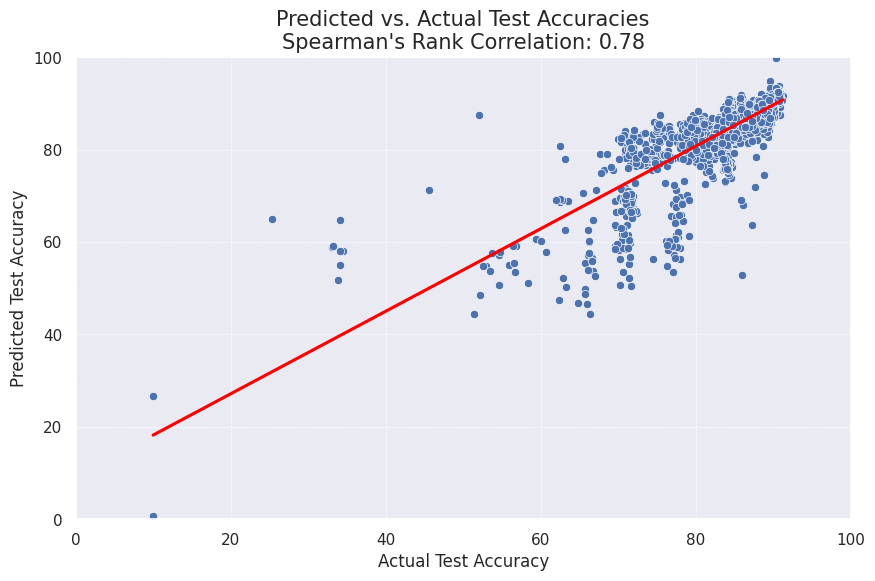

In [37]:
model.eval()  # Set the model to evaluation mode
model.to('cpu')  # Ensure the model is on CPU
predicted_accuracies = []
actual_accuracies = []

with torch.no_grad():  # No need to track gradients
    for i in range(len(inputs_test)):  # Assuming you want to use all test inputs
        input_tensor = inputs_test[i].unsqueeze(0).to('cpu')  # Add batch dimension and ensure it's on CPU
        predicted_accuracy = model(input_tensor)  # Predict
        predicted_accuracies.append(predicted_accuracy.item())
        actual_accuracies.append(targets_test[i].item())

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # Ensure numpy is imported
from scipy.stats import spearmanr

# Convert lists to numpy arrays for plotting
predicted_accuracies_np = np.array(predicted_accuracies)
actual_accuracies_np = np.array(actual_accuracies)

# Calculate Spearman's rank correlation
spearman_corr, _ = spearmanr(predicted_accuracies_np, actual_accuracies_np)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Generate a scatter plot
sns.scatterplot(x=actual_accuracies_np, y=predicted_accuracies_np)

# Beautify the plot
plt.title(f'Predicted vs. Actual Test Accuracies\nSpearman\'s Rank Correlation: {spearman_corr:.2f}', fontsize=15)
plt.xlabel('Actual Test Accuracy', fontsize=12)
plt.ylabel('Predicted Test Accuracy', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Optional: Plot a line of best fit
sns.regplot(x=actual_accuracies_np, y=predicted_accuracies_np, scatter=False, ci=None, color="red")
plt.xlim([0, 100])  # Adjust these limits if necessary
plt.ylim([0, 100])  # Adjust these limits if necessary
plt.show()


## Evaluation on model transfer to other datasets

If network is trained on CIFAR10 how well do the models to transfer to CIFAR100 without retraining

In [ ]:
file = '/home/laurie2905/mase_ADL/mase/NASLib/naslib/data/zc_nasbench201.json'
with open(file, 'r') as f:
    data = json.load(f)
    data = data['cifar100']


targets = [data[arch]['val_accuracy'] for arch in data.keys()]
inputs = []

for arch in data.keys():

    inputs.append([data[arch].get(metric_name, 0)['score'] for metric_name in ['epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot','plain','snip','synflow','zen','flops','params'] ])
    

In [ ]:
from torchsummary import summary


# Create a new model instance with the architecture parameters of the best model
model = DynamicModel(
    input_size=13,
    num_layers=study.best_trial.params['num_layers'],
    hidden_units=study.best_trial.params['hidden_units'],
    output_size=1
)

# Load the best model's state dictionary
model.load_state_dict(torch.load('saved_models/best_model.pth'))

model.to('cuda')

# Print the model summary
# You need to know the input size of your model; for example, (13,) for 13 input features
summary(model, input_size=(13,))

In [ ]:
model.eval()  # Set the model to evaluation mode
model.to('cpu')  # Ensure the model is on CPU
predicted_accuracies = []
actual_accuracies = []

with torch.no_grad():  # No need to track gradients
    for i in range(len(inputs_test)):  # Assuming you want to use all test inputs
        input_tensor = inputs_test[i].unsqueeze(0).to('cpu')  # Add batch dimension and ensure it's on CPU
        predicted_accuracy = model(input_tensor)  # Predict
        predicted_accuracies.append(predicted_accuracy.item())
        actual_accuracies.append(targets_test[i].item())

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # Ensure numpy is imported
from scipy.stats import spearmanr

# Convert lists to numpy arrays for plotting
predicted_accuracies_np = np.array(predicted_accuracies)
actual_accuracies_np = np.array(actual_accuracies)

# Calculate Spearman's rank correlation
spearman_corr, _ = spearmanr(predicted_accuracies_np, actual_accuracies_np)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Generate a scatter plot
sns.scatterplot(x=actual_accuracies_np, y=predicted_accuracies_np)

# Beautify the plot
plt.title(f'Predicted vs. Actual Test Accuracies\nSpearman\'s Rank Correlation: {spearman_corr:.2f}', fontsize=15)
plt.xlabel('Actual Test Accuracy', fontsize=12)
plt.ylabel('Predicted Test Accuracy', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Optional: Plot a line of best fit
sns.regplot(x=actual_accuracies_np, y=predicted_accuracies_np, scatter=False, ci=None, color="red")
plt.xlim([0, 100])  # Adjust these limits if necessary
plt.ylim([0, 100])  # Adjust these limits if necessary
plt.show()
